In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.Ml_methods import Ml_methods
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import wandb
from scipy import stats
from scipy.stats import linregress
import copy
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel, cosine_distances
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import plotly.express as px
import math

Constants

In [3]:
params_to_work_with = constants.ALL_PARAMS
outliers = ['PD028_YO', 'PD037_ES', 'PD044_TS', 'PD056_YK', 'PD004_KC']

Load the data and proccess it

In [7]:
def load_data(data_path, rois, outliers=[]):
    col_names = ['subjects', 'Age', 'Gender', 'Clinc_group']
    subjects_raw_data = DataProcessor(
        data_path, rois, rois, col_names).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(
        subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(
        analyzed_data, rois, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]

    ctl_subjects = chosen_data[chosen_data.Clinc_group == 'CTL']
    pd_subjects = chosen_data[chosen_data.Clinc_group == 'PD']

    return chosen_data, ctl_subjects, pd_subjects

### Cortex

In [9]:
all_data_cortex_raw, ctl_data_cortex_raw, pd_data_cortex_raw = load_data(
    constants.PATH_TO_PD_CORTEX_all_params_raw,
    constants.ROI_CORTEX,
    outliers=outliers)
all_data_cortex_z_score, ctl_data_cortex_z_score, pd_data_cortex_z_score = load_data(
    constants.PATH_TO_PD_CORTEX_all_params_z_score,
    constants.ROI_CORTEX,
    outliers=outliers)

print(
    f'num ctl: {ctl_data_cortex_raw.subjects.nunique()}, num pd: {pd_data_cortex_raw.subjects.nunique()}')

num ctl: 19, num pd: 27


### Gray subcortex

In [12]:
all_data_g_subcortex_raw, ctl_data_g_subcortex_raw, pd_data_g_subcortex_raw = load_data(
    constants.PATH_TO_PD_SUB_CORTEX_all_params_raw,
    constants.ROI_SUBCORTEX,
    outliers=outliers)
all_data_g_subcortex_z_score, ctl_data_g_subcortex_z_score, pd_data_g_subcortex_z_score = load_data(
    constants.PATH_TO_PD_SUB_CORTEX_all_params_z_score, 
    constants.ROI_SUBCORTEX,
    outliers=outliers)

print(
    f'num ctl: {ctl_data_g_subcortex_raw.subjects.nunique()}, num pd: {pd_data_g_subcortex_raw.subjects.nunique()}')

num ctl: 19, num pd: 27


In [15]:
chosen_data_z_score = pd.concat([all_data_cortex_z_score, all_data_g_subcortex_z_score])
chosen_data_raw = pd.concat([all_data_cortex_raw, all_data_g_subcortex_raw])
ctl_data_raw = pd.concat([ctl_data_cortex_raw, ctl_data_g_subcortex_raw])
pd_data_raw = pd.concat([pd_data_cortex_raw, pd_data_g_subcortex_raw])
ctl_data_z_score = pd.concat([ctl_data_cortex_z_score, ctl_data_g_subcortex_z_score])
pd_data_z_score = pd.concat([pd_data_cortex_z_score, pd_data_g_subcortex_z_score])

t_test showed no significance difference, p = 0.9579910136983862


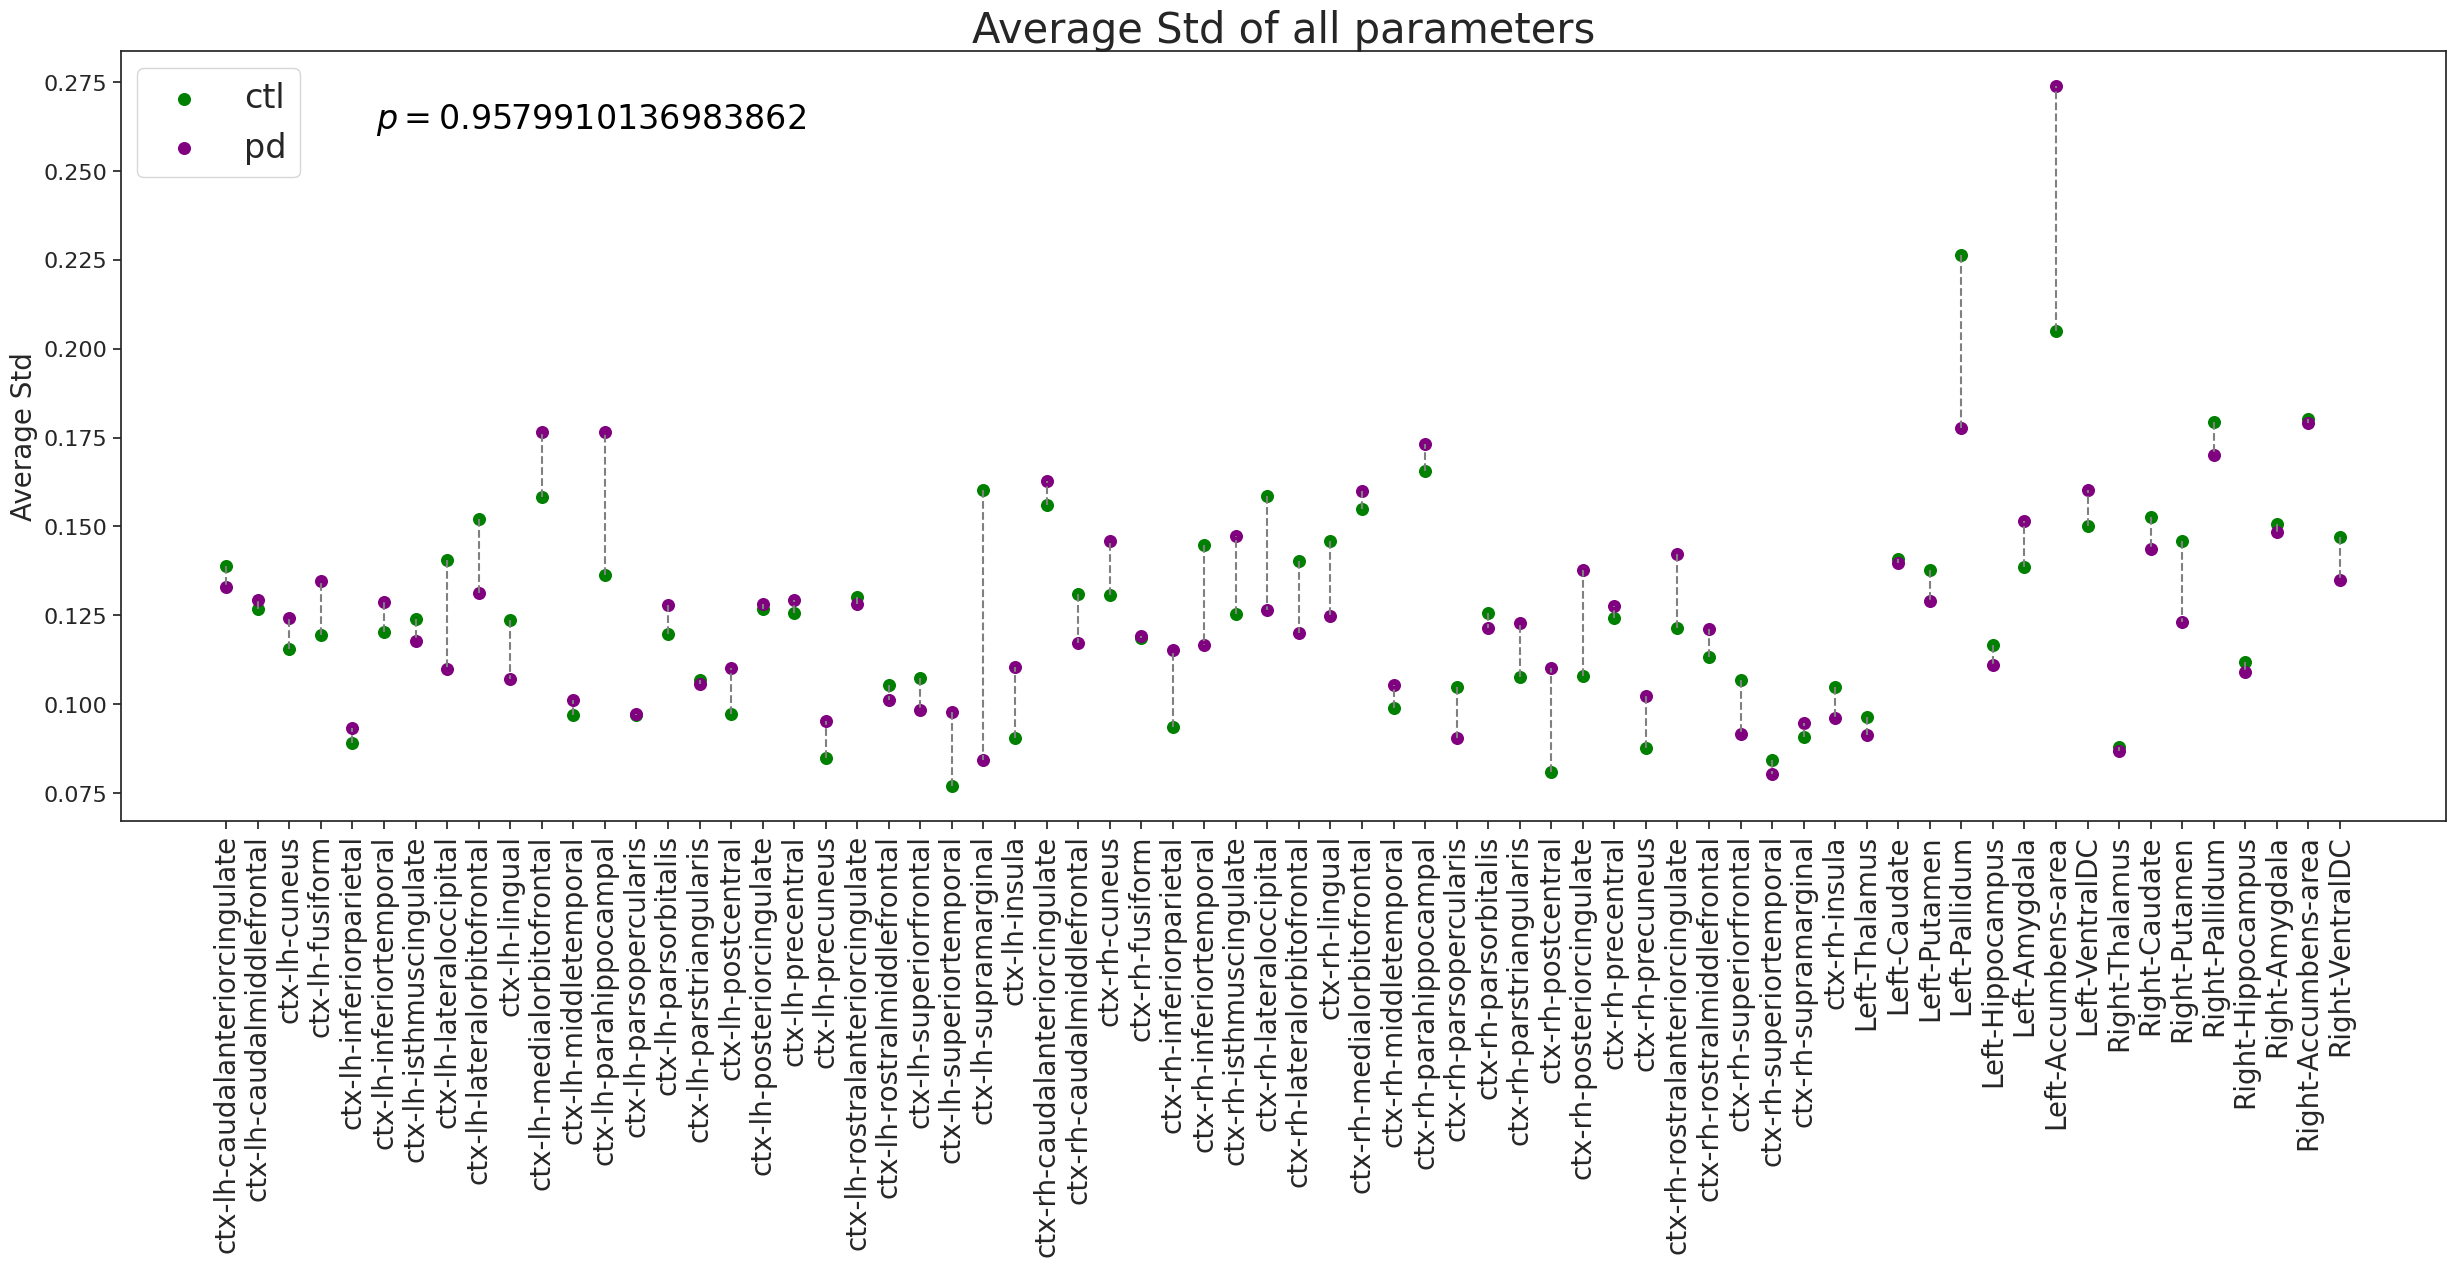

In [28]:
%autoreload 2
data_groups = [(ctl_data_z_score, 'green', 'ctl'), (pd_data_z_score, 'purple', 'pd')]
groups_stds = StatisticsWrapper.calculate_mean_std_for_rois(data_groups, constants.ROI_CORTEX_AND_GRAY_SUB_CORTEX.values(), params_to_work_with, fig_size=(30, 10), t_test_params=('ctl', 'pd'))

## Check correlations on the normalized data

In [77]:
def show_correlations_stats(all_data, young_data, old_data, method, linkage_method, divide=False):
    ordered_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, linkage_method,
                                                             title="all")['dendrogram_data']['ivl']
    young_clusters = StatisticsWrapper.hierarchical_clustering(young_data, params_to_work_with, linkage_method,
                                                             title="young")
    old_clusters = StatisticsWrapper.hierarchical_clustering(old_data, params_to_work_with, linkage_method,
                                                             title="old")
    if divide:
        ordered_rois = sorted(ordered_rois, key=custom_sort_key)
        young_result = correlations_by_sub_systems(
            young_data, ordered_rois, method, 'young', show=False)
        old_result = correlations_by_sub_systems(
            old_data, ordered_rois, method, 'old', show=False)

        PlotsManager.plot_heatmap(
            young_result, 'Correlations of young group, divided by neuroanatomical regions', project_name=None)
        PlotsManager.plot_heatmap(
            old_result, 'Correlations of old group, divided by neuroanatomical regions', project_name=None)
        
        cluster_by_subsystem(young_data, old_data, linkage_method)
    else:
        young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, ordered_rois,
                                                          group_title='Correlations of young group', method=method)
        old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, ordered_rois,
                                                        group_title='Correlations of old group', method=method)

    PlotsManager.plot_heatmap(
        old_result - young_result, 'differences of old and young', project_name=None)

    young_corr_means, old_corr_means = show_corr_mean(
        young_result, old_result, ordered_rois, f"ROI average correlations {'for each neuroanatomical region' if divide else ''}", divide)

    return young_clusters, old_clusters, young_corr_means, old_corr_means

def show_corr_mean(young_result, old_result, ordered_rois, title, divide=False):
    np.fill_diagonal(young_result.values, 0)
    np.fill_diagonal(old_result.values, 0)
    young_result['corr_mean'] = young_result.apply(np.mean, axis=1)
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1)

    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f'{title}', fontsize=20)
    ax.scatter(ordered_rois, young_result['corr_mean'].to_numpy(
    ), color='green', s=40, label='young')
    ax.scatter(ordered_rois, old_result['corr_mean'].to_numpy(
    ), color='purple', s=40, label='old')
    
    if divide:
        add_dividers(ax, min(young_result['corr_mean'].to_numpy()))      
        ax.set_xticks([])
    else:
        ax.set_xticks(ordered_rois)
        ax.set_xticklabels(ordered_rois, rotation='vertical', fontsize=14)

        # add p value
        results = stats.ttest_ind(a=young_result['corr_mean'], b=old_result['corr_mean'])
        p_val_str = constants.SUPERSCRIPTS[round(math.log10(results.pvalue))]
        plt.text(0.12, 0.90, f"$p < 10{p_val_str}$", fontsize=22, color='black', transform=plt.gca().transAxes)

    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel("Average correlation", fontsize=22)
    # Connecting the points with vertical lines
    for x, y1, y2 in zip(ordered_rois, young_result['corr_mean'].to_numpy(), old_result['corr_mean'].to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='dotted')

    ax.grid(True, which='both', linestyle='--', linewidth=0.6)
    ax.legend(fontsize=14, loc="upper left")
    ax.set_facecolor('white')

    return young_result['corr_mean'], old_result['corr_mean']


def show_distances(method, params_to_work_with, all_data, young_subjects, old_subjects, title):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(
        all_data, params_to_work_with, 'single', title="all")['dendrogram_data']['ivl']
    young_distances = StatisticsWrapper.roi_distances(
        young_subjects, params_to_work_with, clusters_rois, method=method, title=f'Young rois {title}')
    old_distances = StatisticsWrapper.roi_distances(
        old_subjects, params_to_work_with, clusters_rois, method=method, title=f'Old rois {title}')

    _, __ = show_corr_mean(young_distances, old_distances,
                           clusters_rois, f'Average ROIS {title}')


def custom_sort_key(s):
    if s.startswith('ctx'):
        return (0, s)  # First priority
    elif s.startswith('wm'):
        return (1, s)  # Second priority
    else:
        return (2, s)  # Third priority


def divide_rois(ordered_rois, custom_sort_key):
    wm_group = []
    ctx_group = []
    other_group = []

    for roi in ordered_rois:
        key = custom_sort_key(roi)
        if key[0] == 0:
            ctx_group.append(roi)
        elif key[0] == 1:
            wm_group.append(roi)
        else:
            other_group.append(roi)

    return wm_group, ctx_group, other_group


def correlations_by_sub_systems(data, ordered_rois, method, group_name, show):
    # Divide ROIs into subgroups
    wm_rois, ctx_rois, sub_gray_rois = divide_rois(
        ordered_rois, custom_sort_key)

    # Initialize lists to store results
    results = []

    # Perform correlation analysis for each subgroup
    for subgroup in [ctx_rois, wm_rois, sub_gray_rois]:
        result = StatisticsWrapper.roi_correlations(data[data['ROI_name'].isin(subgroup)], params_to_work_with, subgroup,
                                                    group_title=f'Correlations of {group_name} group', method=method, show=show)
        results.append(result)

    # Concatenate the results
    return pd.concat(results)

def add_dividers(ax: plt.Axes, min_loc):
    ctx_values = {"name": 'Cortex', "start": -1, "end": len(constants.ROI_CORTEX) - 0.3, "color": 'green'}
    wm_values = {"name": 'White matter', "start": len(constants.ROI_CORTEX) -0.3, "end": len(constants.ROI_CORTEX) + len(constants.ROI_WM) - 0.3, "color": 'yellow'}
    sub_g_values = {"name": 'Subcortical', "start": len(constants.ROI_CORTEX) + len(constants.ROI_WM) -0.3,
                     "end": len(constants.ROI_CORTEX) + len(constants.ROI_WM) + len(constants.ROI_SUBCORTEX) + 1, "color": 'pink'}
    divide_values = [ctx_values, wm_values, sub_g_values]
    
    for divide_value in divide_values:
        ax.axvline(divide_value['end'], alpha=0.5, linestyle='--', linewidth=2)
        ax.text((divide_value['start'] + divide_value['end']) / 2, min_loc-0.05, divide_value['name'], ha='center', va='center', fontsize=18)    

    ax.text(0.12, min_loc-0.02, f"$p < 10{constants.SUPERSCRIPTS[-6]}$", fontsize=18, color='black', transform=plt.gca().transAxes)
    ax.text(0.50, min_loc-0.02, f"$p > 10{constants.SUPERSCRIPTS[-2]}$", fontsize=16, color='black', transform=plt.gca().transAxes)
    ax.text(0.85, min_loc-0.02, f"$p > 10{constants.SUPERSCRIPTS[-1]}$", fontsize=16, color='black', transform=plt.gca().transAxes)

def check_groups_intersection(group1, group2):
    set1 = set(group1)
    set2 = set(group2)
    intersection = set1.intersection(set2)
    num_same_strings = len(intersection)
    print(f'length set1 :{len(set1)}. length set2: {len(set2)}, intersection: {num_same_strings}')

def cluster_by_subsystem(young_data, old_data, linkage_method):
    rois_groups = [constants.ROI_CORTEX, constants.ROI_WM]
    
    for roi_group in rois_groups:
        young_data_subsystem = young_data[young_data['ROI'].isin(roi_group)]
        old_data_subsystem = old_data[old_data['ROI'].isin(roi_group)]

        young_clusters = StatisticsWrapper.hierarchical_clustering(young_data_subsystem, params_to_work_with, linkage_method,
                                                                title="young")
        old_clusters = StatisticsWrapper.hierarchical_clustering(old_data_subsystem, params_to_work_with, linkage_method,
                                                                title="old")


## Gray cortex, gray sub cortex, white sub cortex 

### Check correlations of the entire regions with each other

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



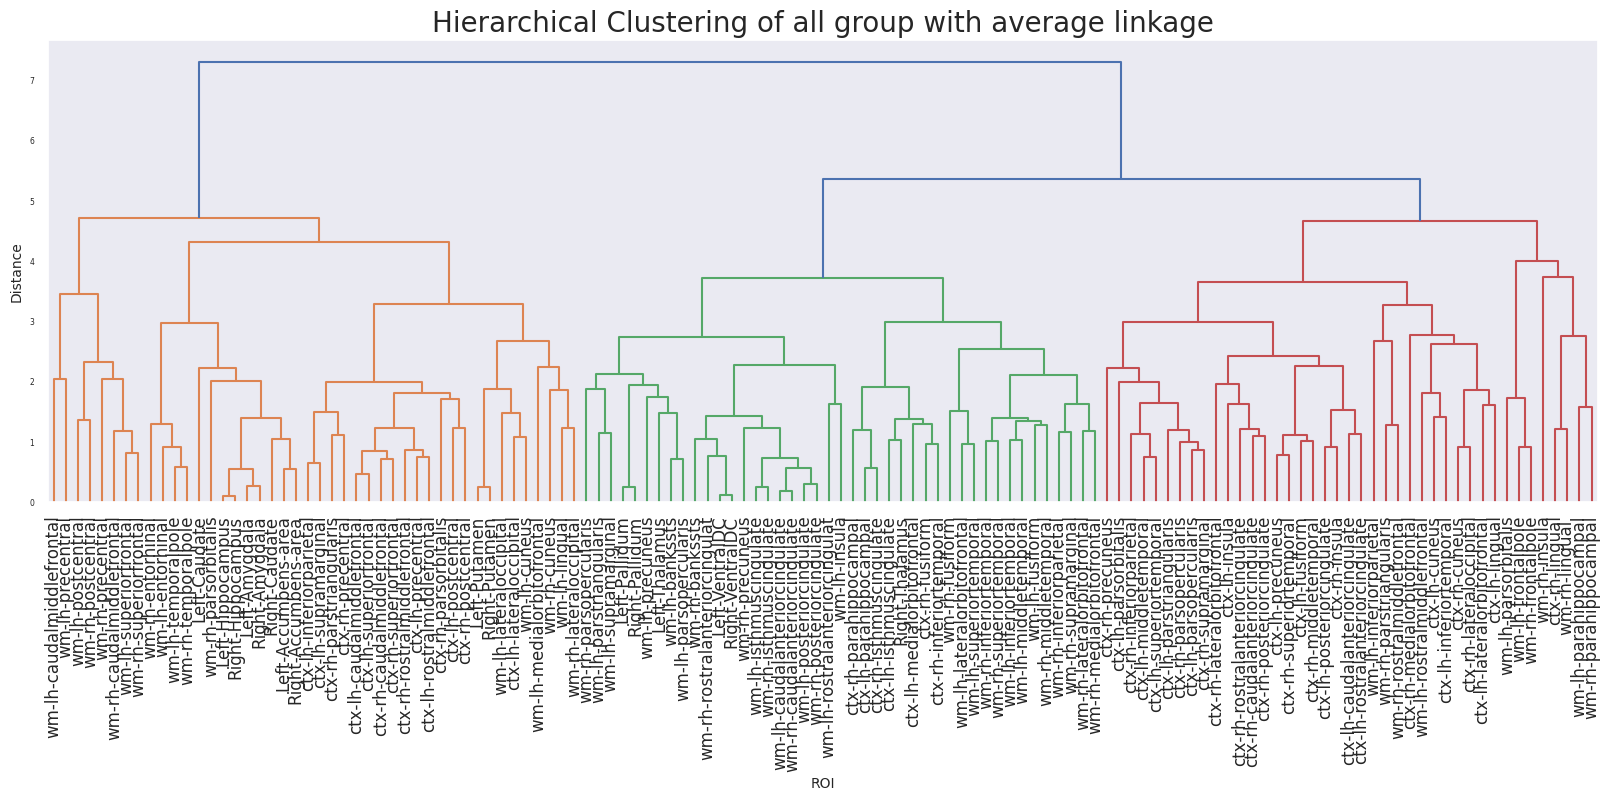

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



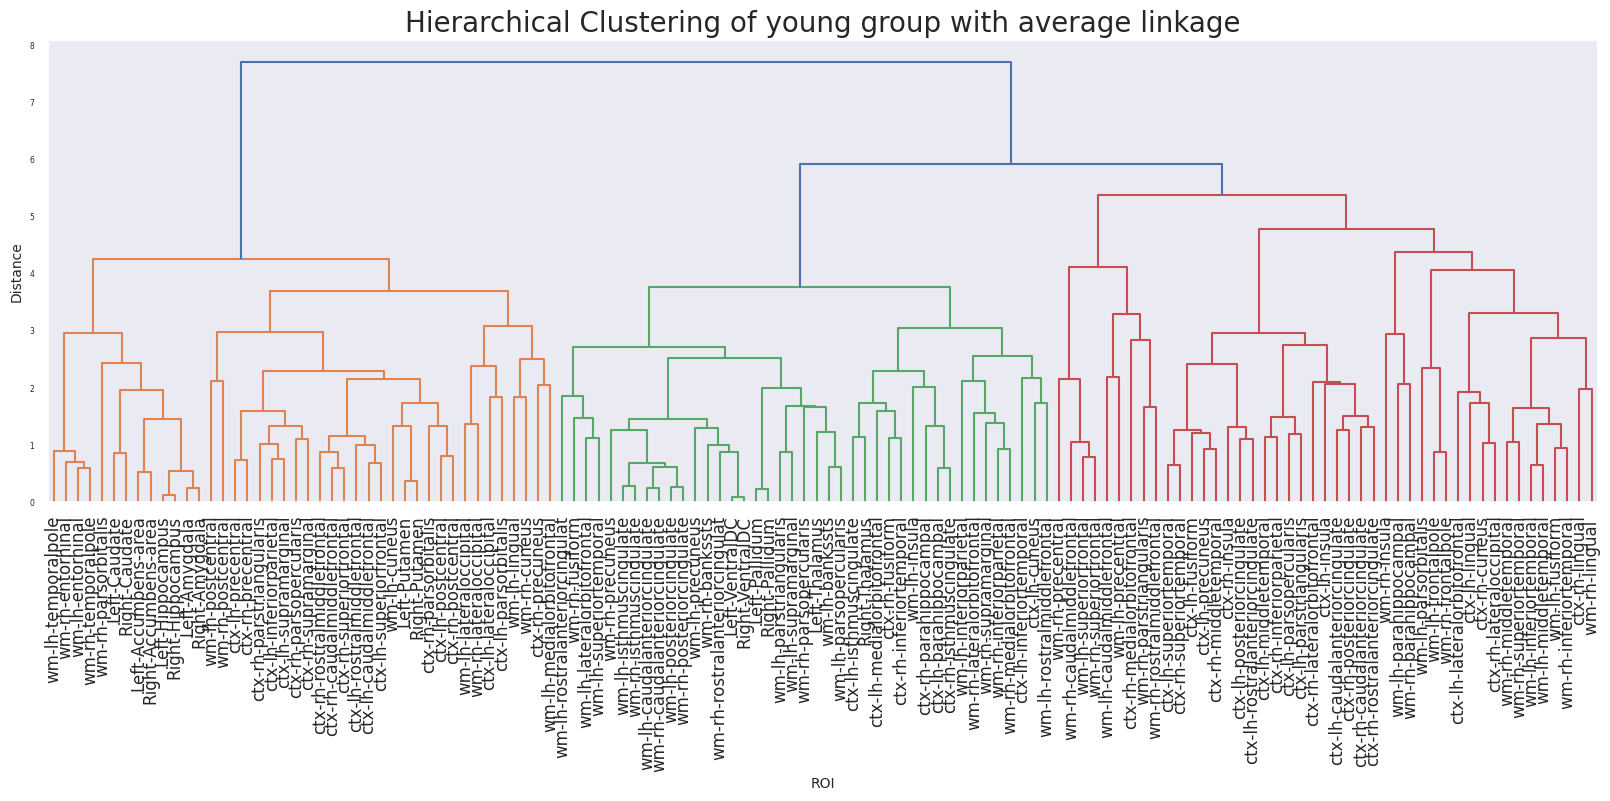

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



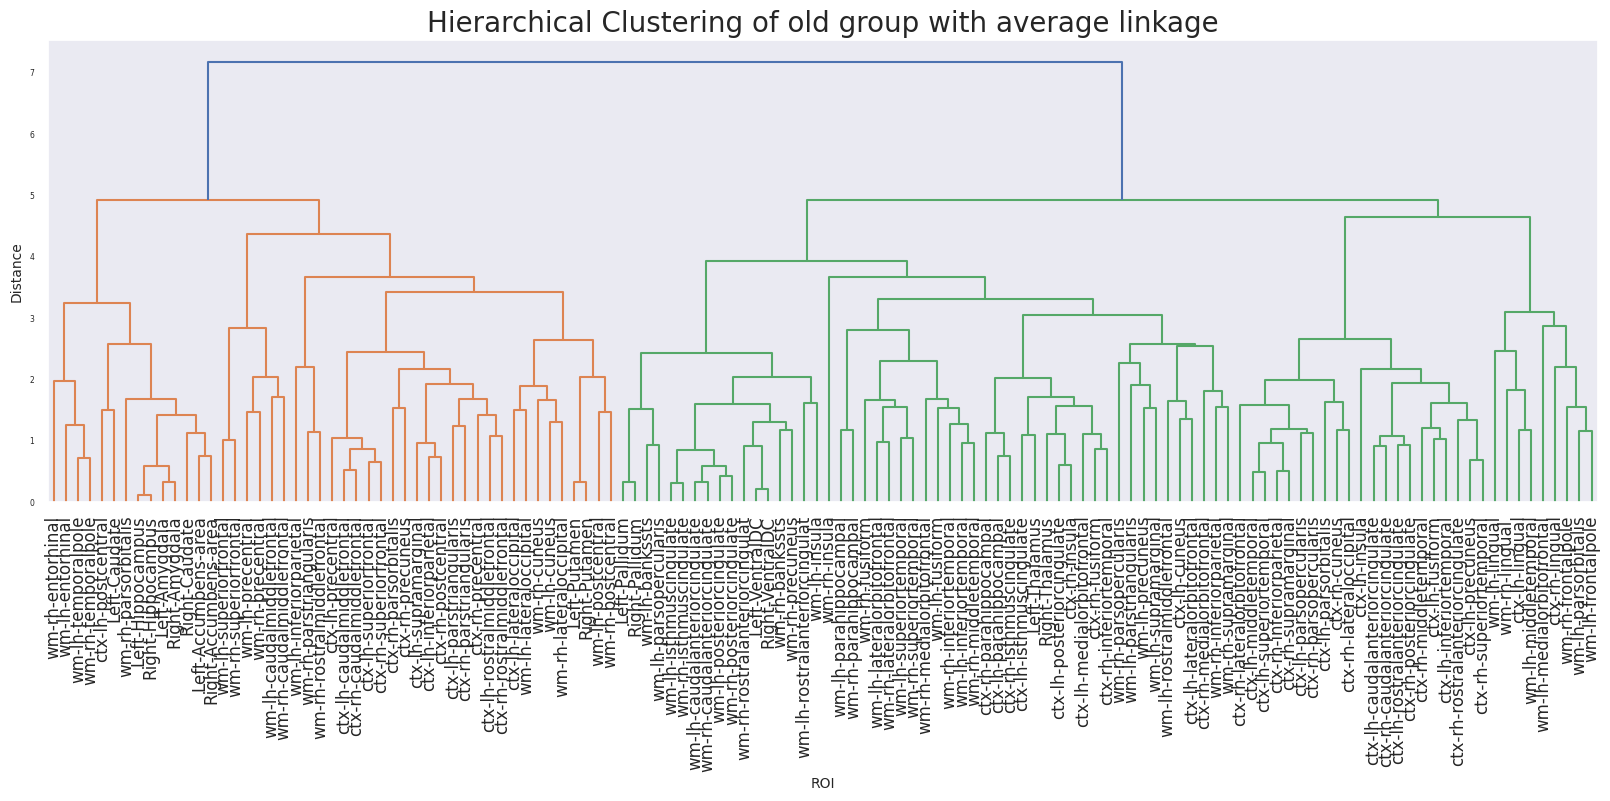

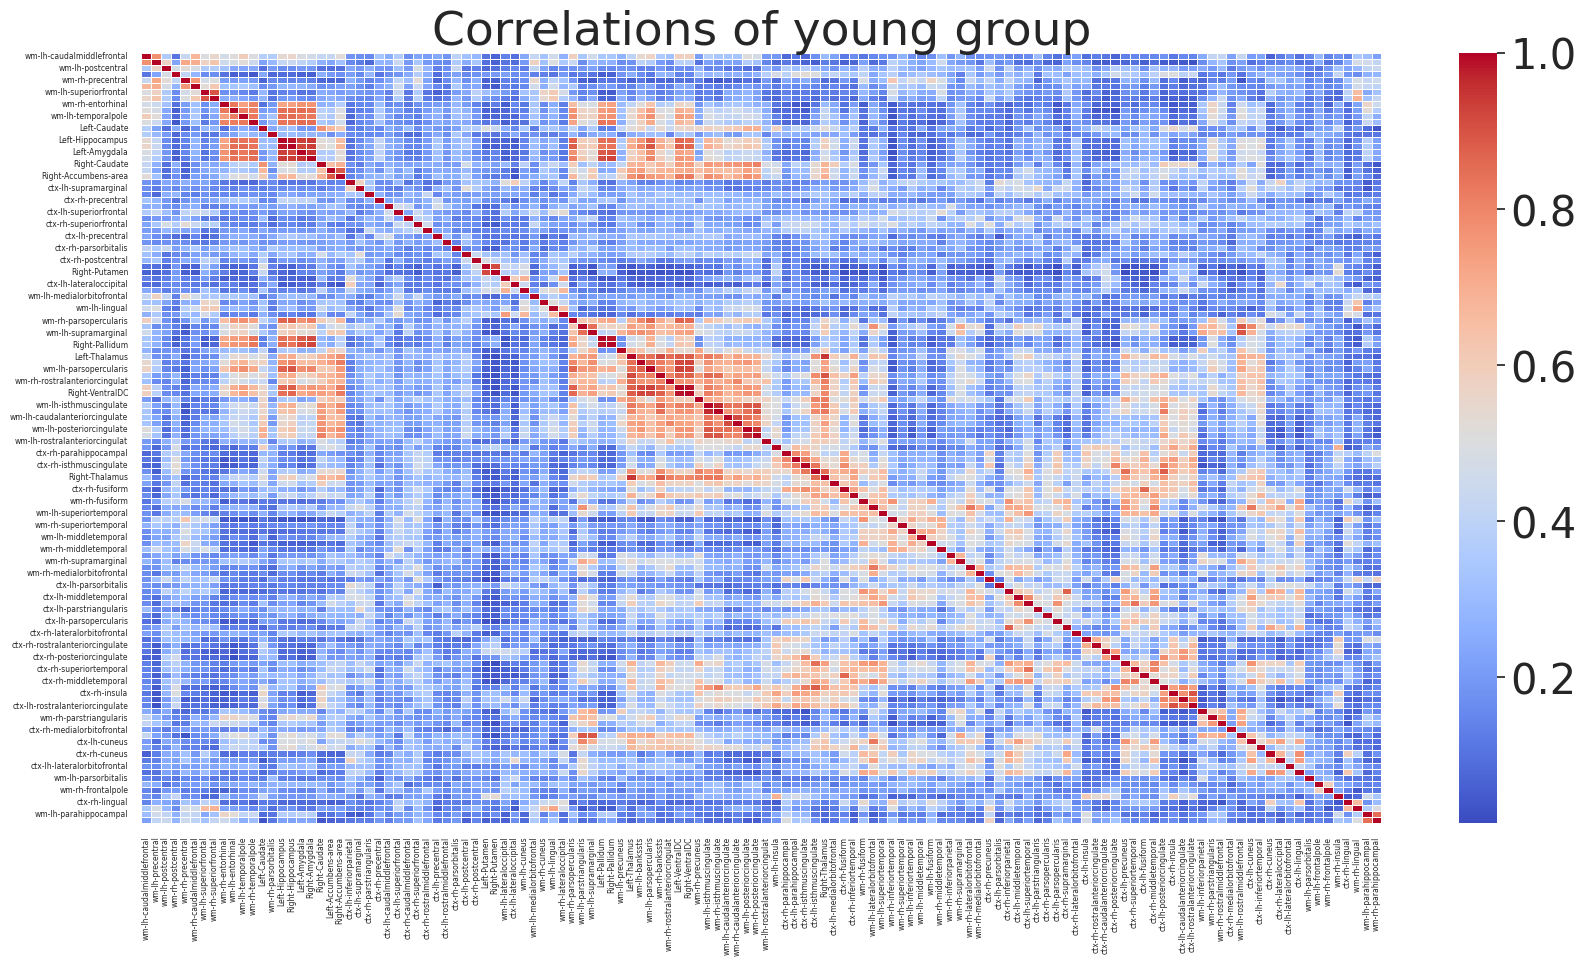

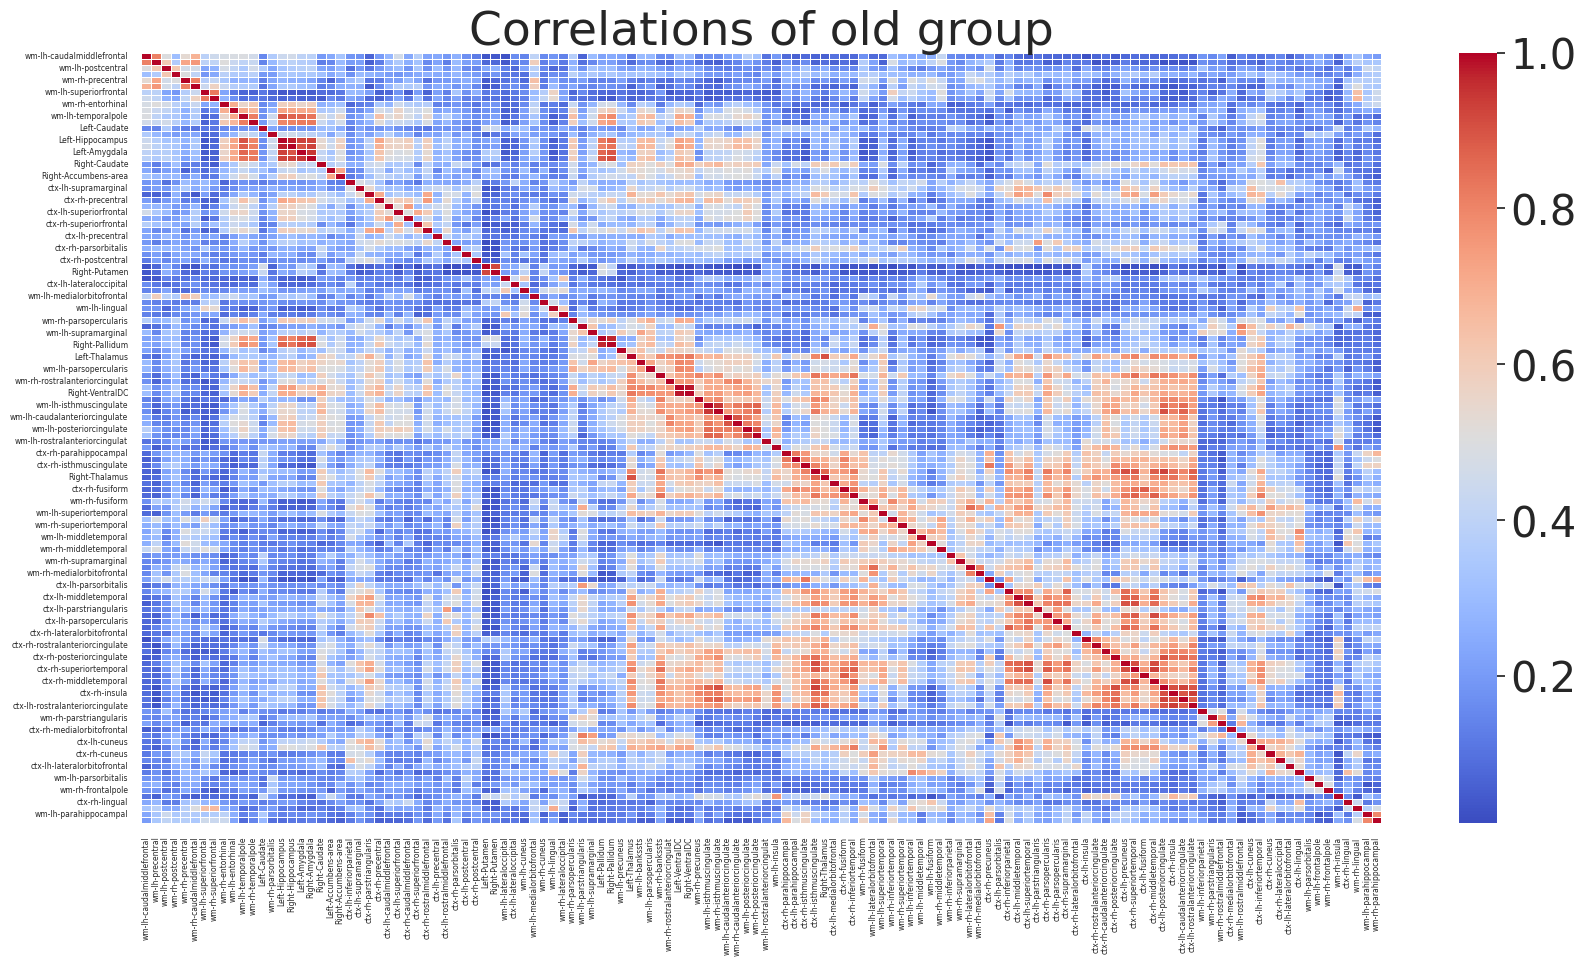

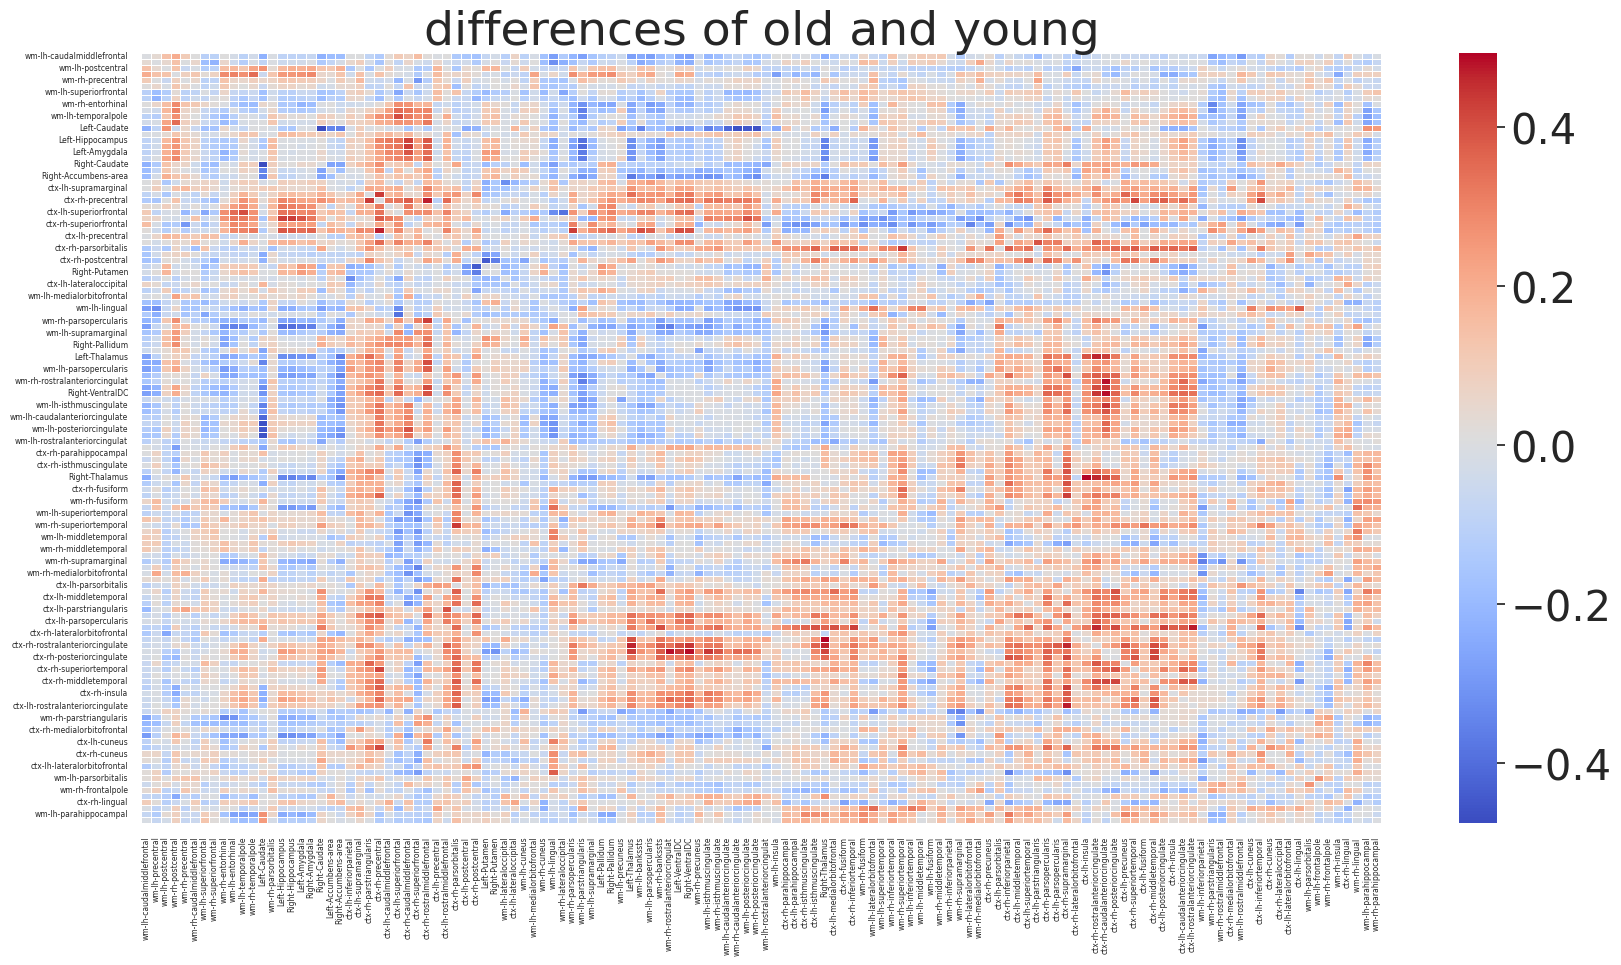

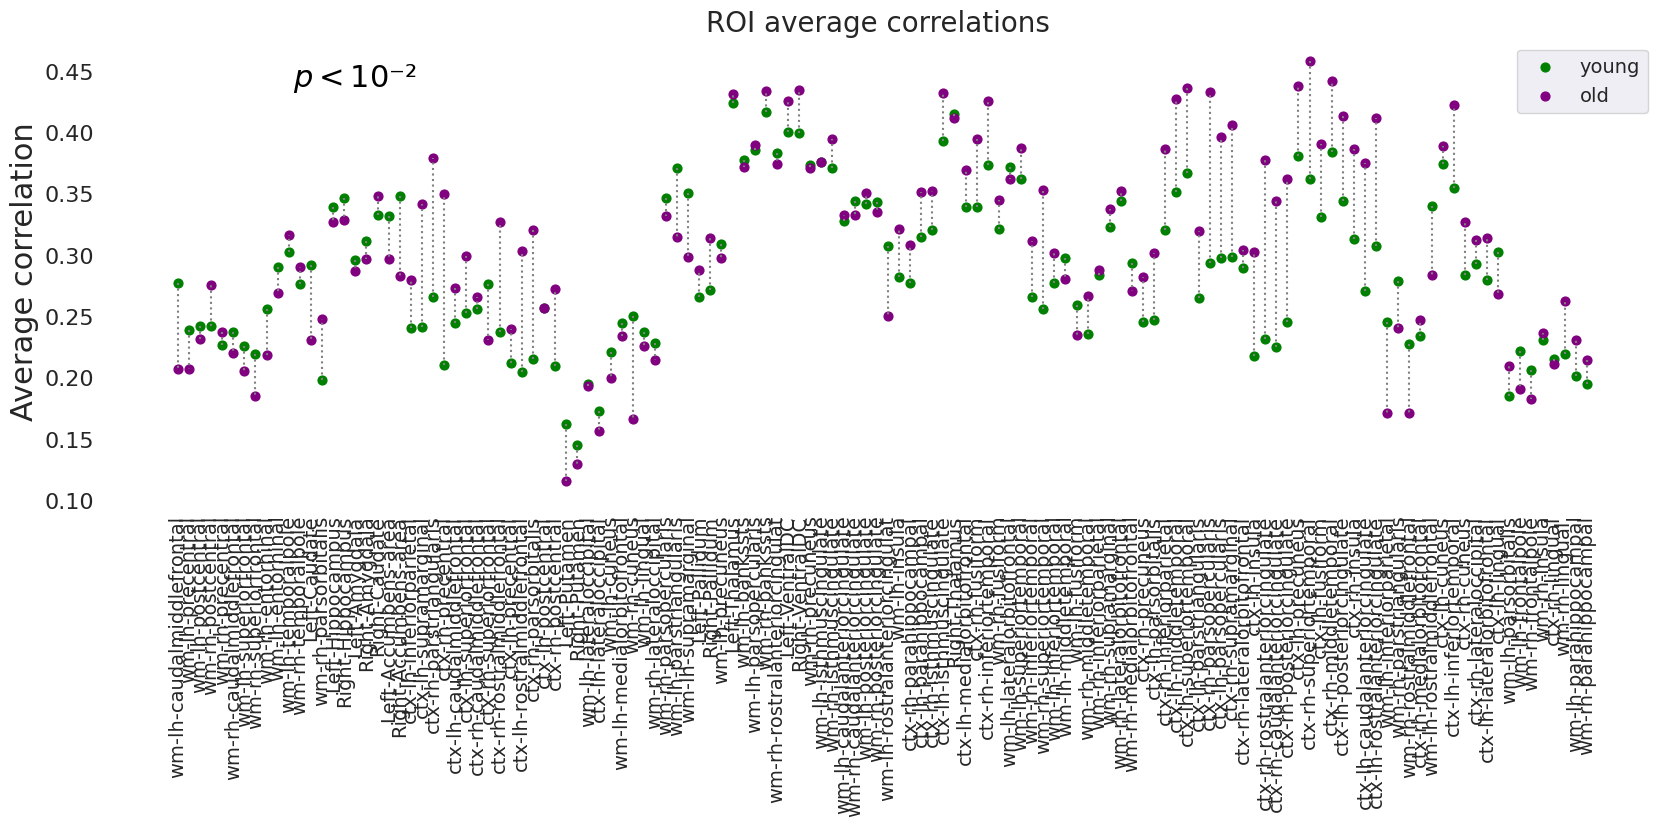

In [47]:
%autoreload 2
young_clusters, old_clusters, young_means, old_means = show_correlations_stats(chosen_data_z_score, young_data_z_score, old_data_z_score, 'pearson', linkage_method='average')

Check correlations of each neuroanatomical region by itself

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



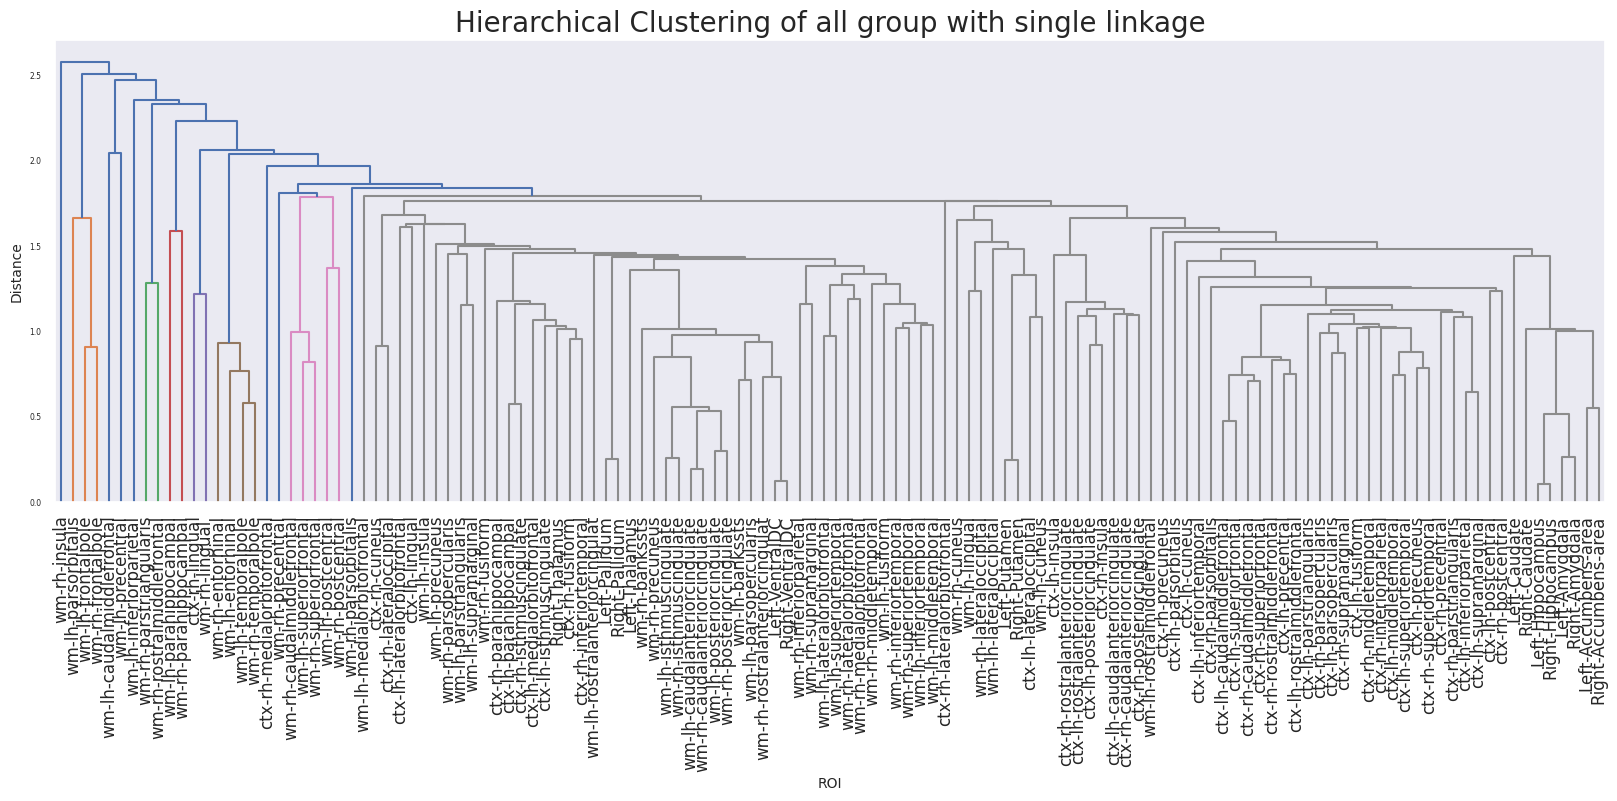

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



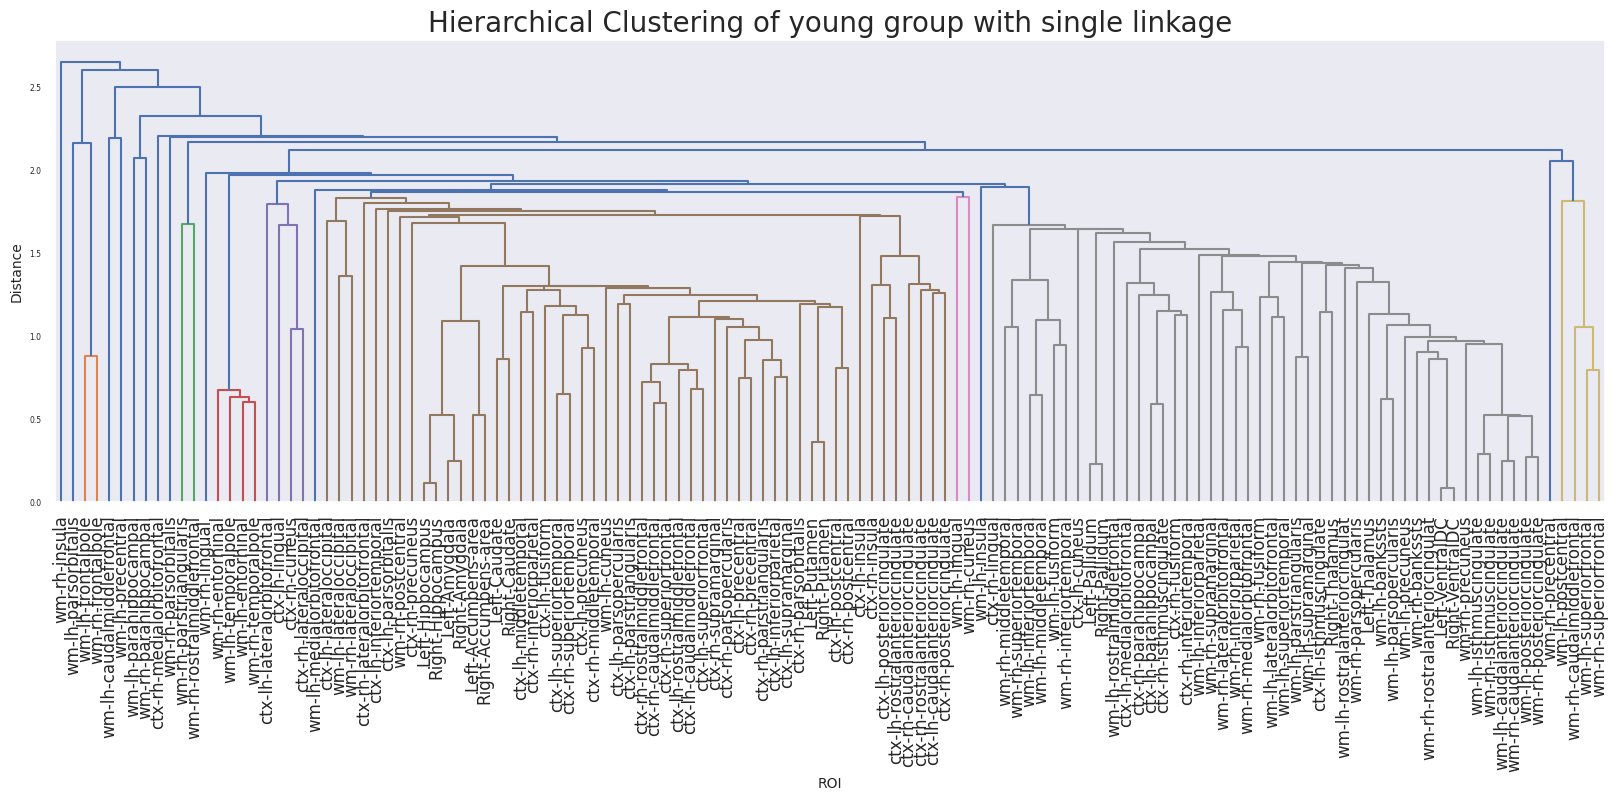

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



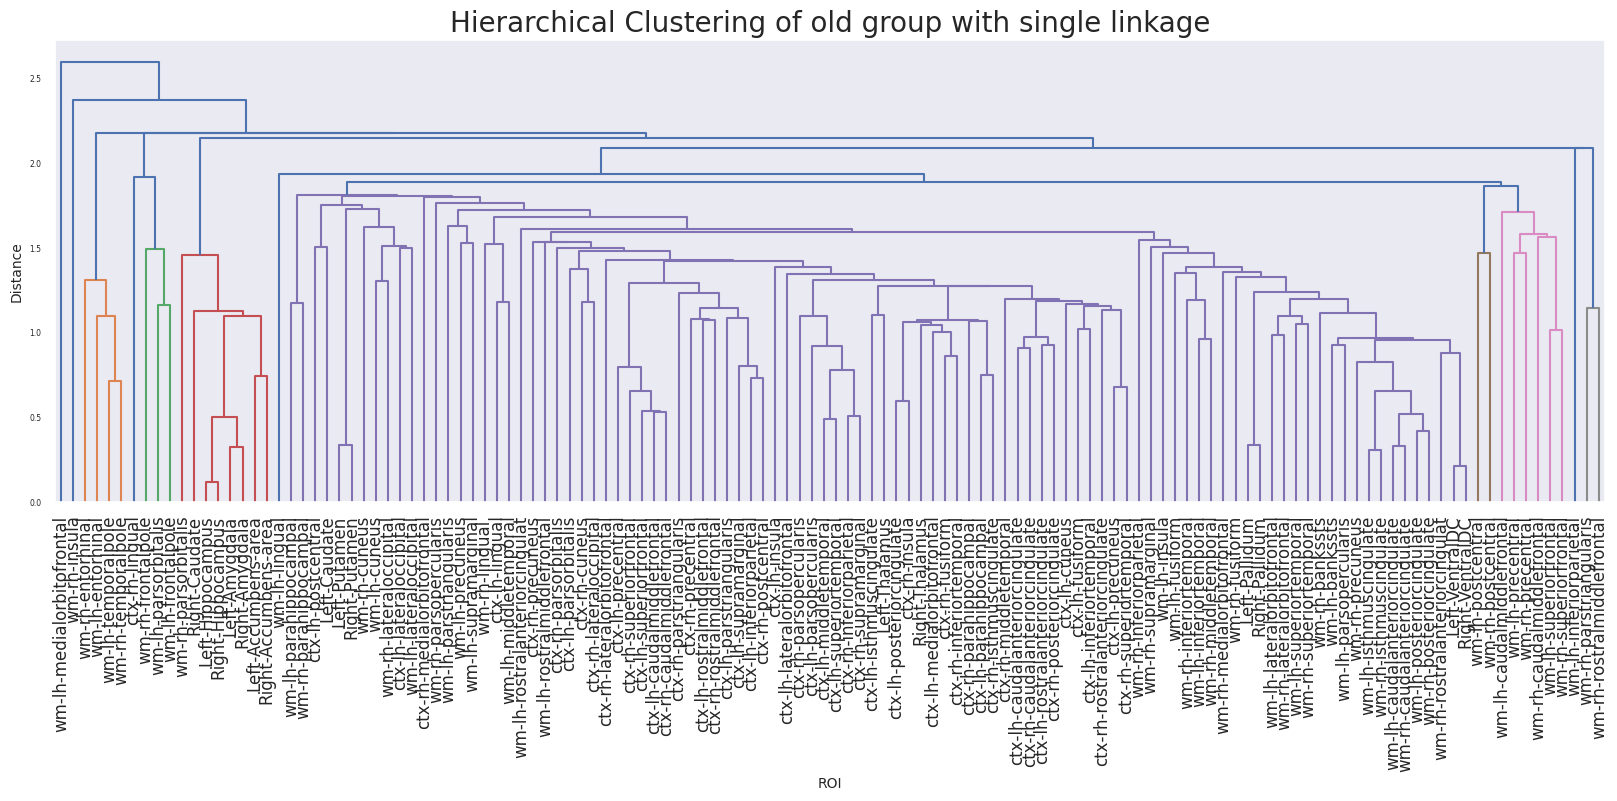

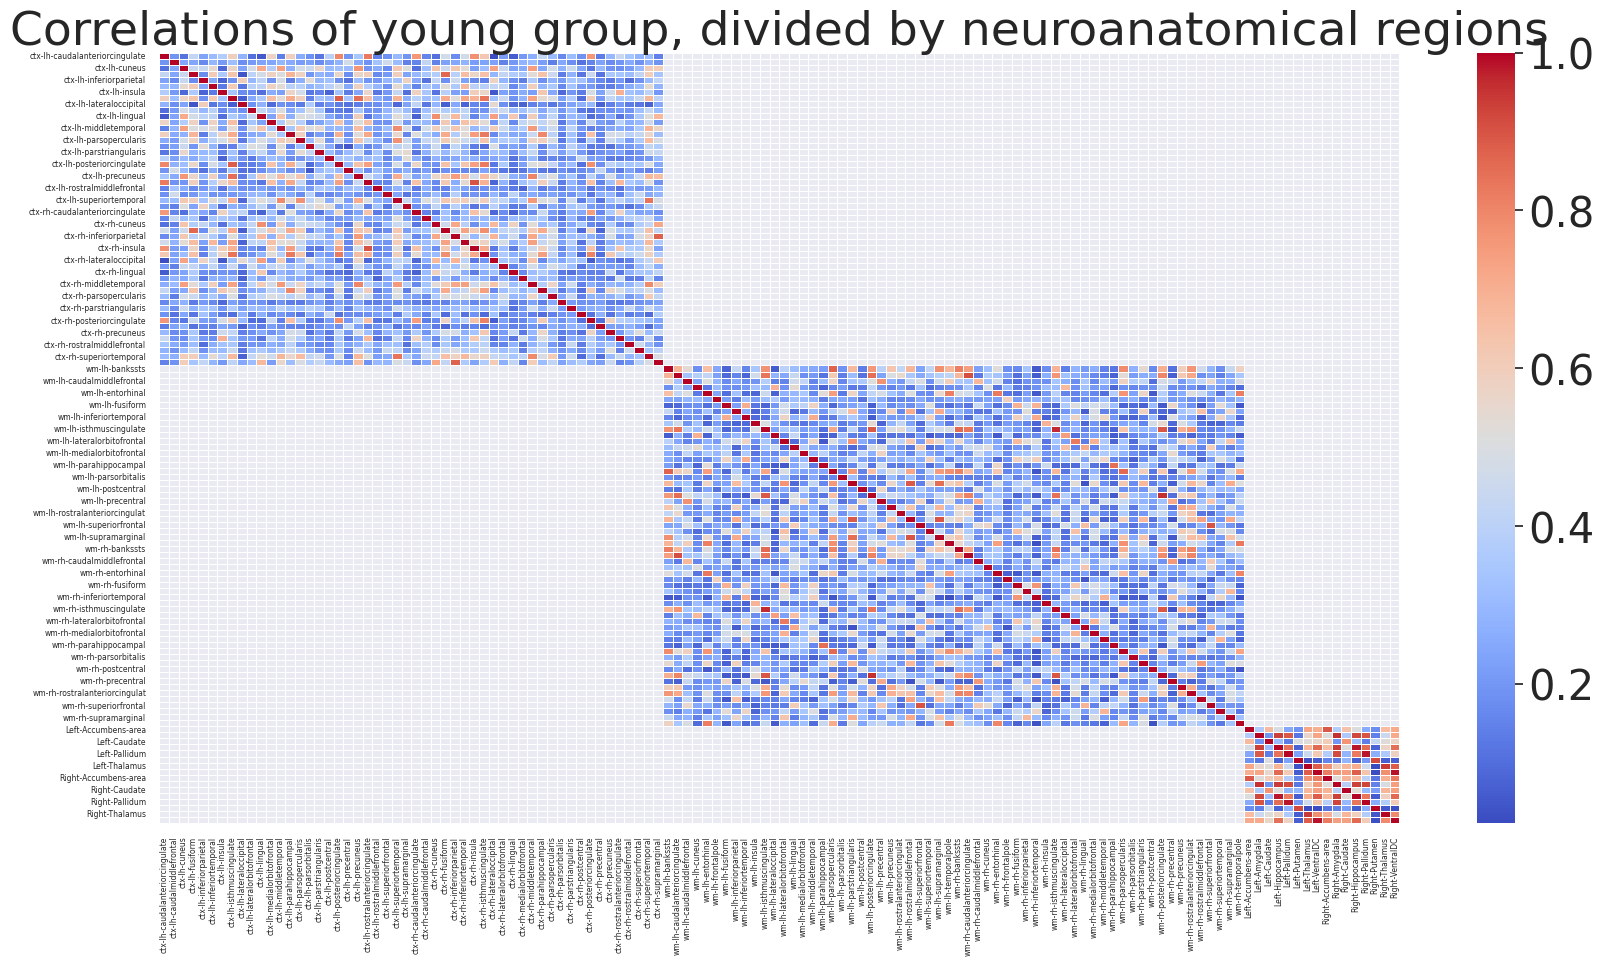

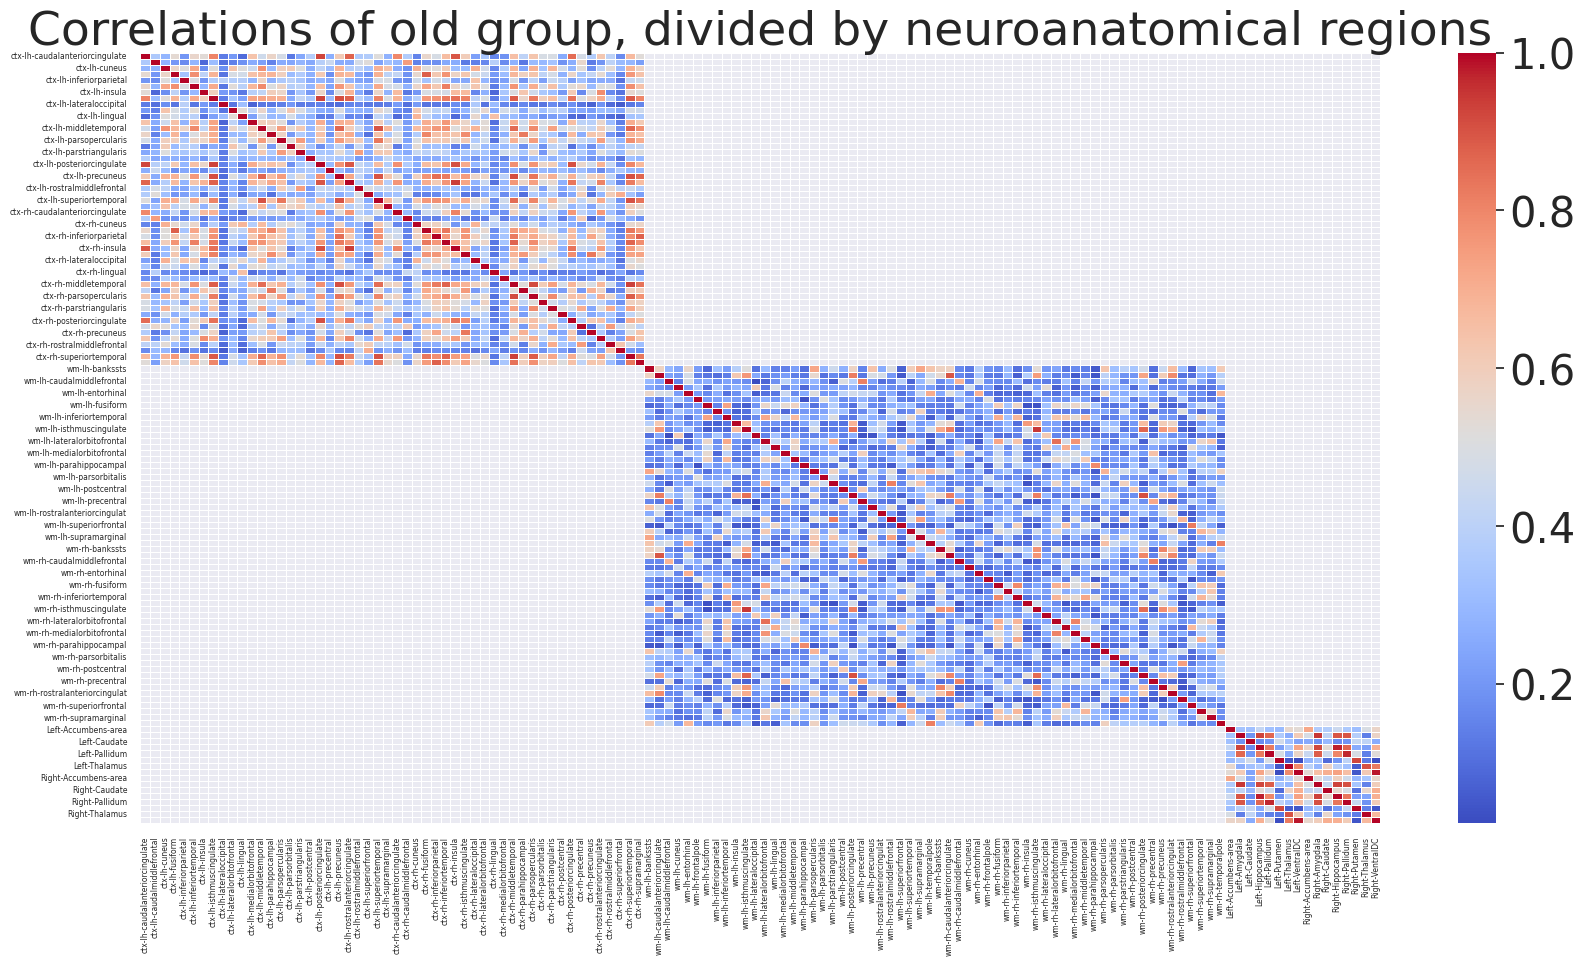

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



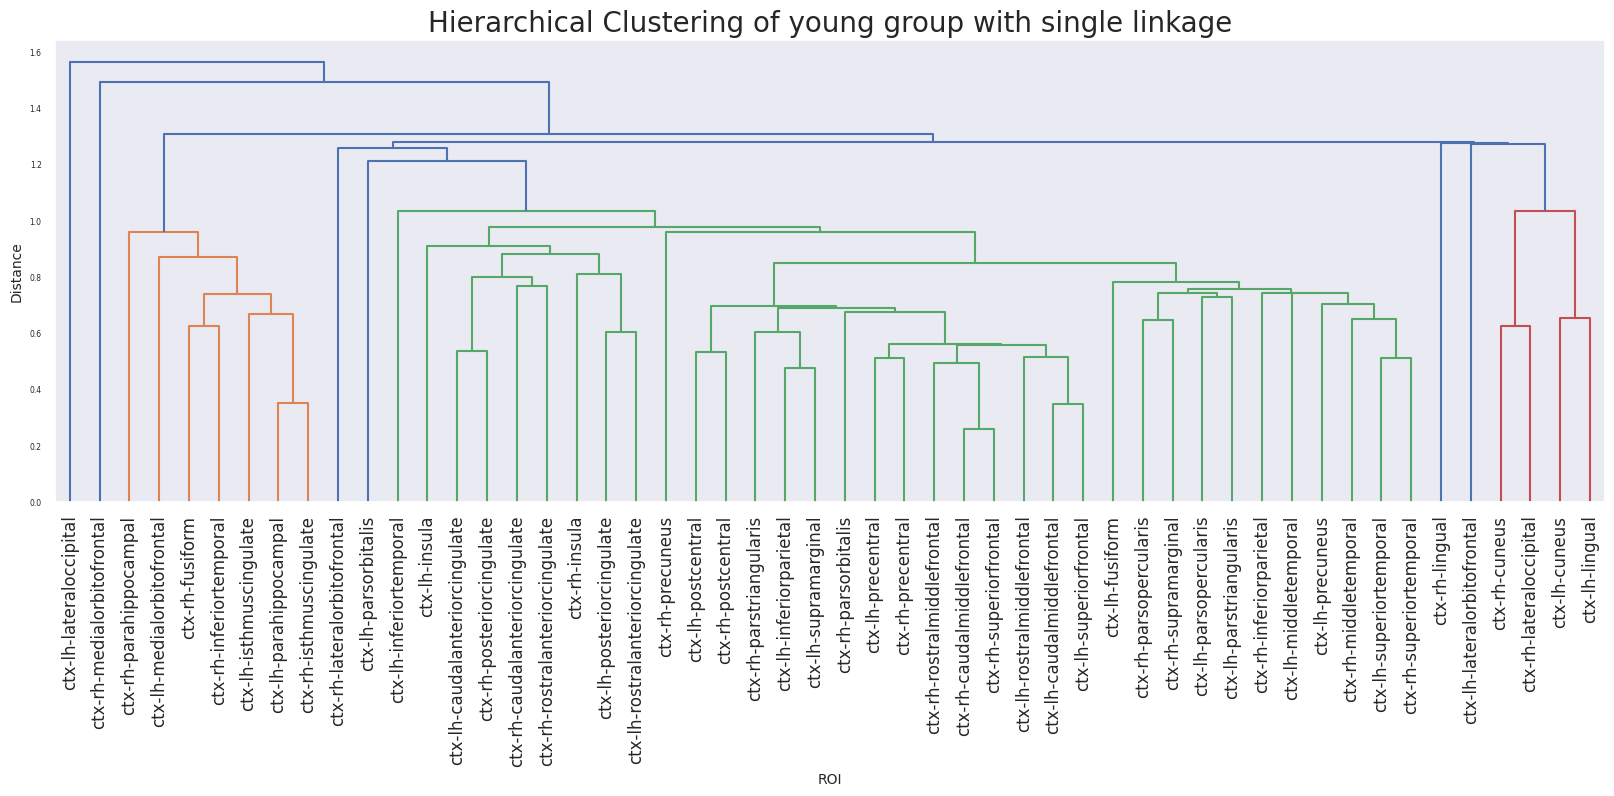

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



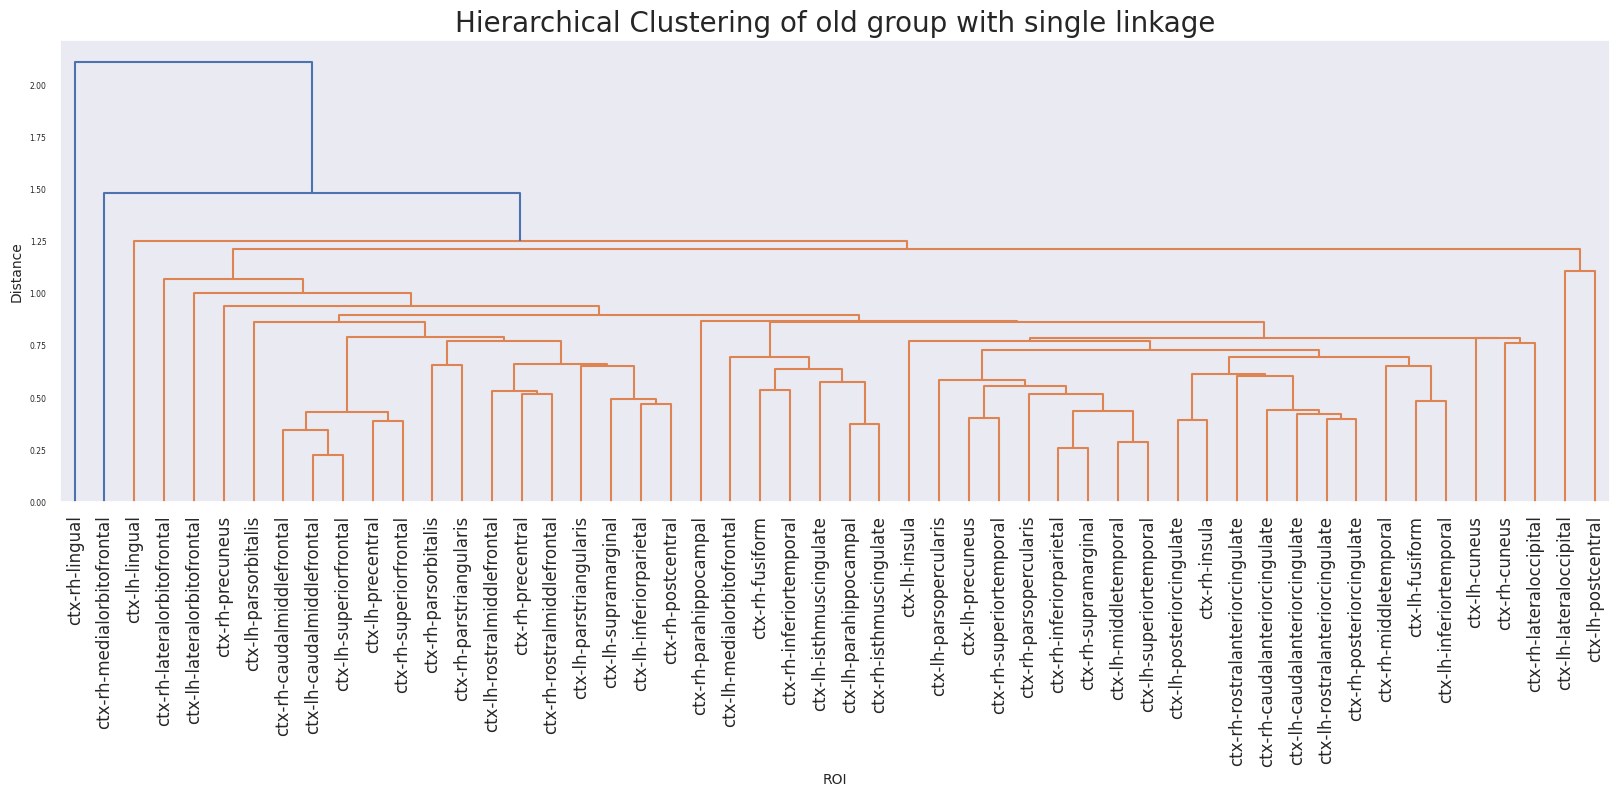

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



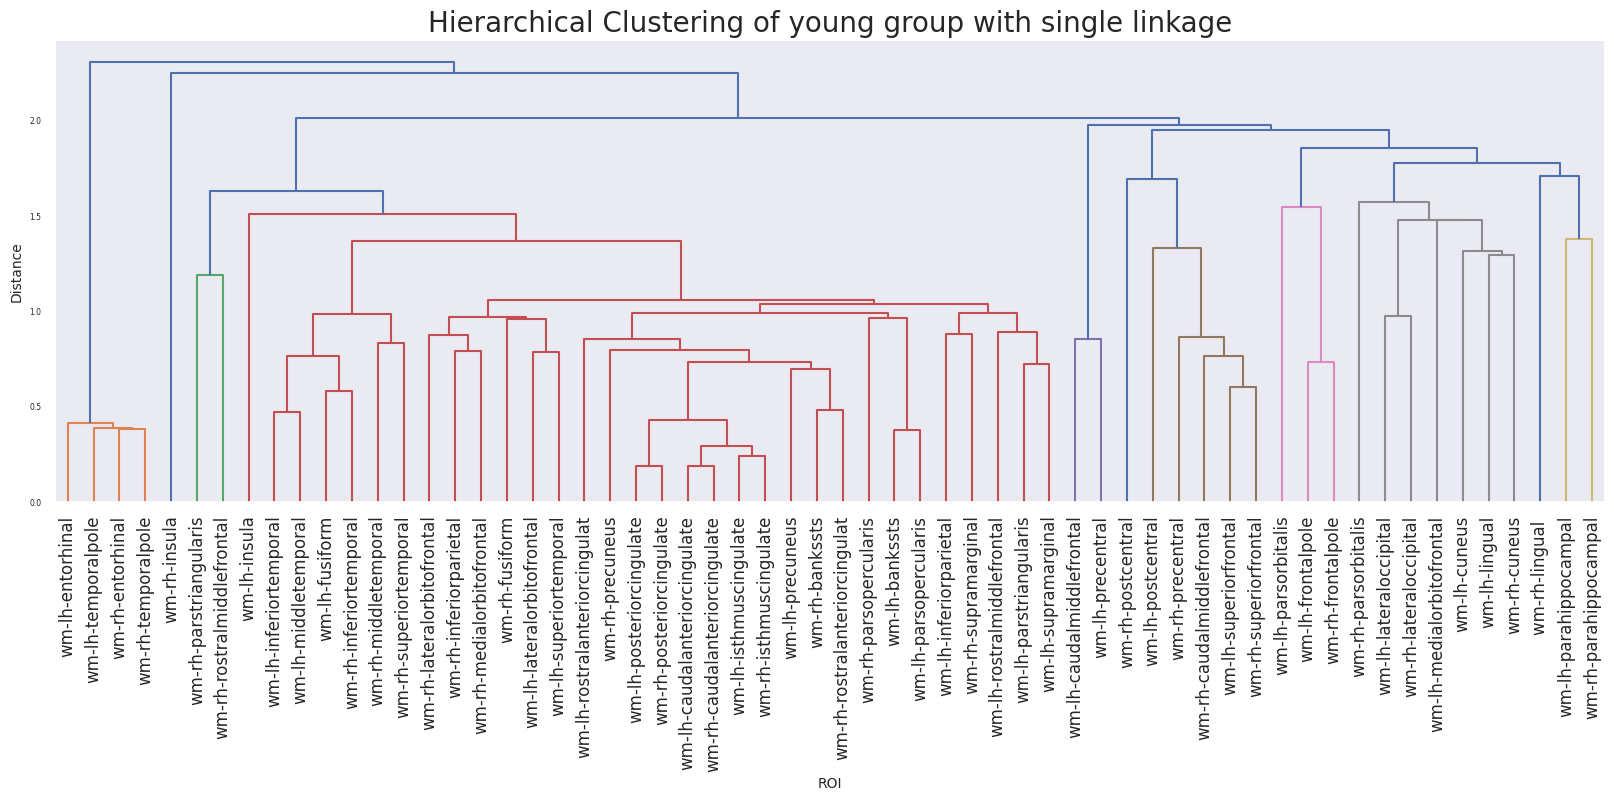

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



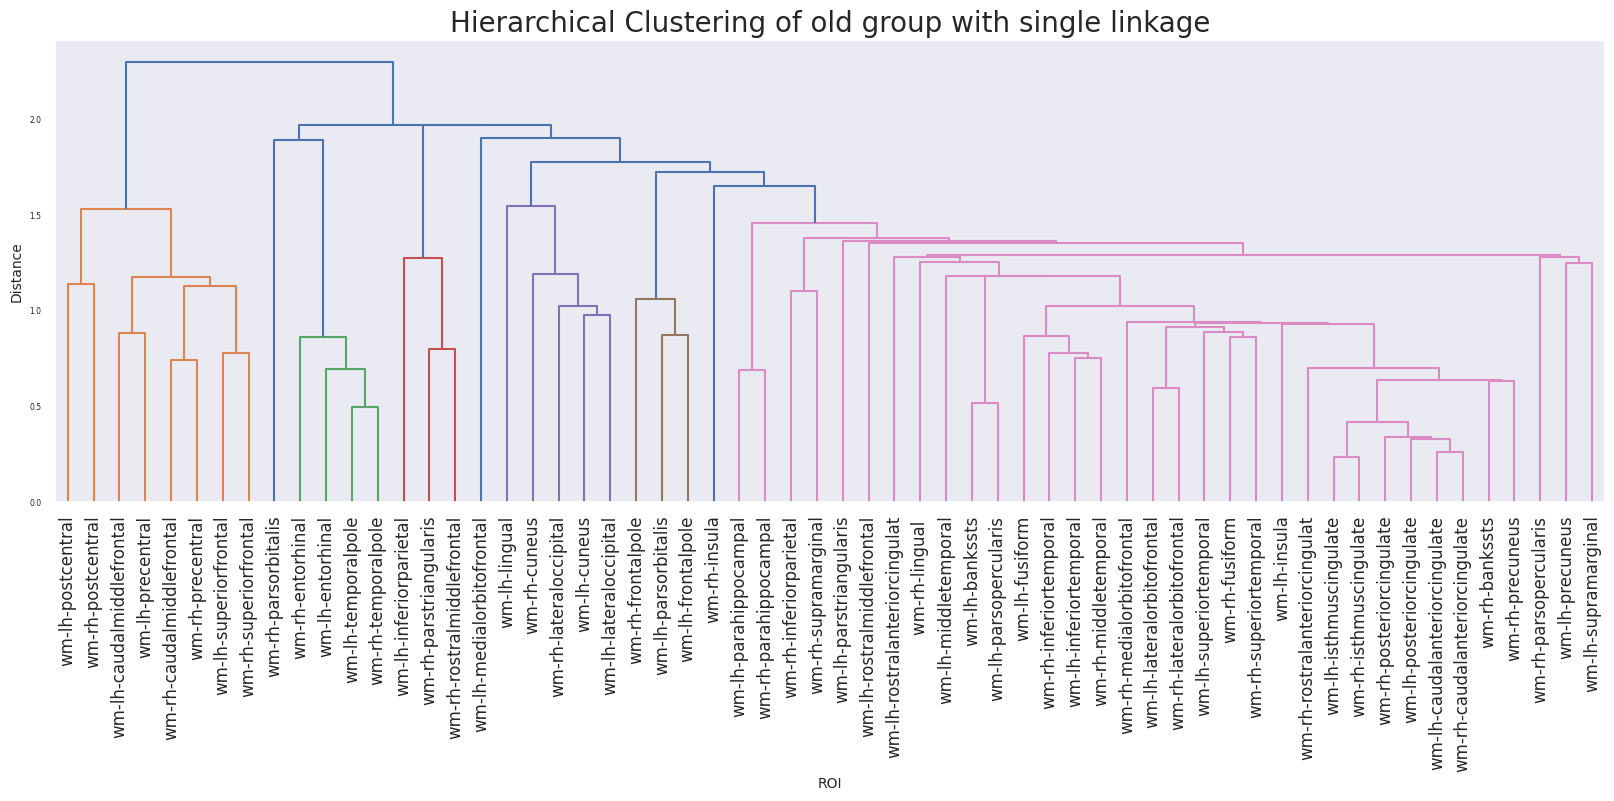

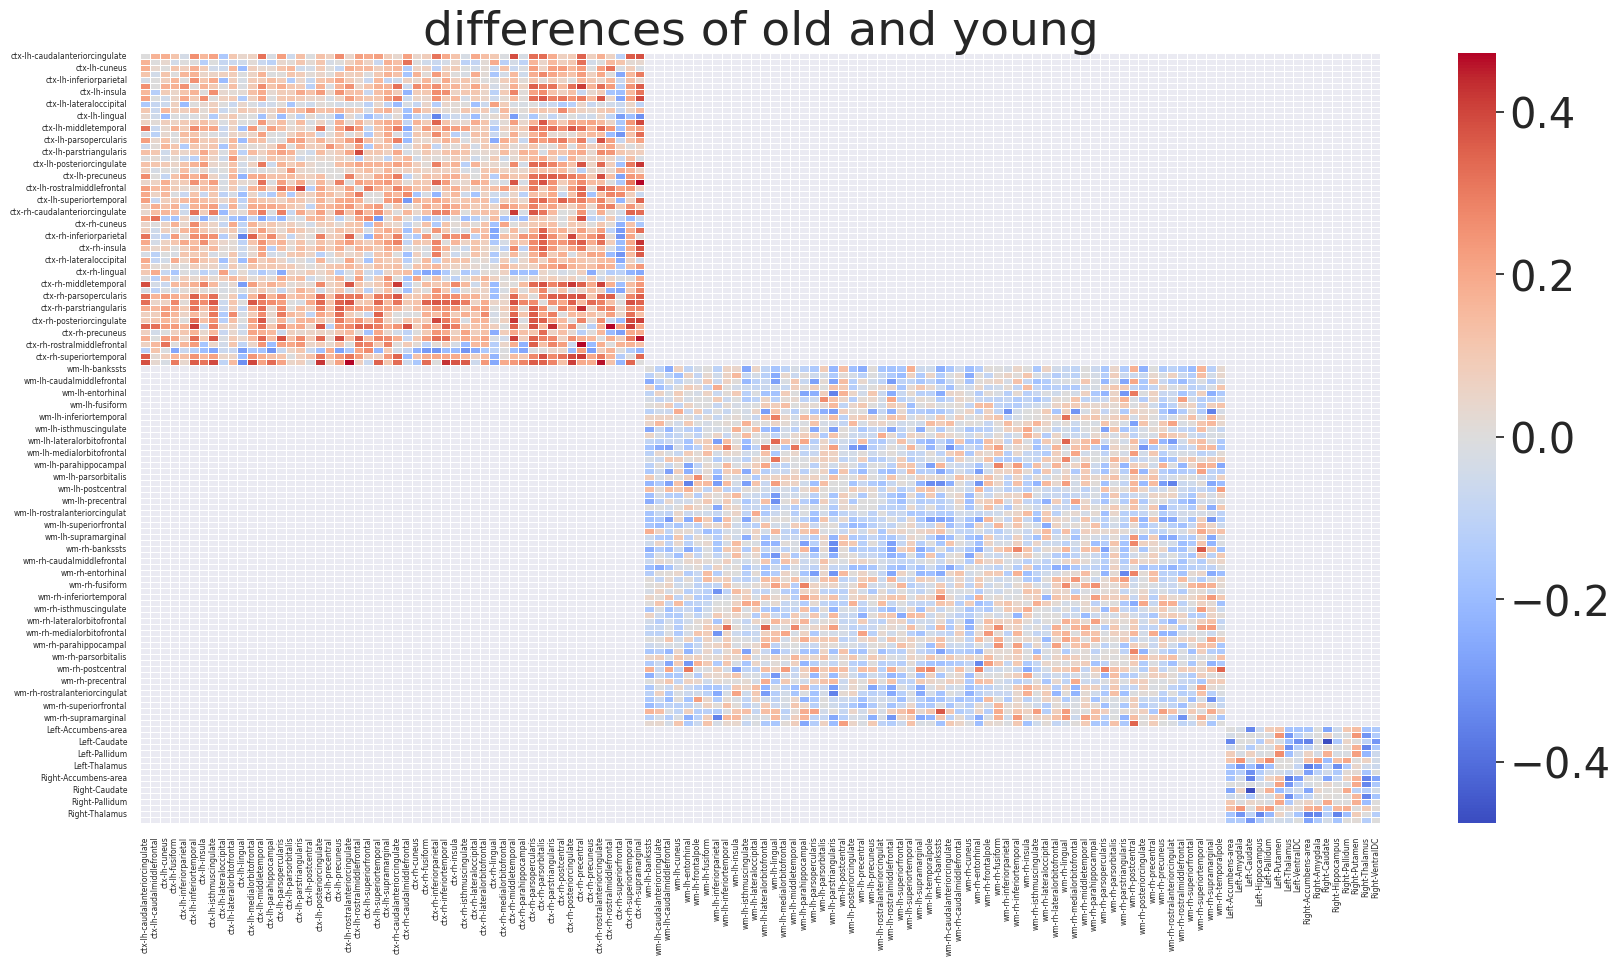

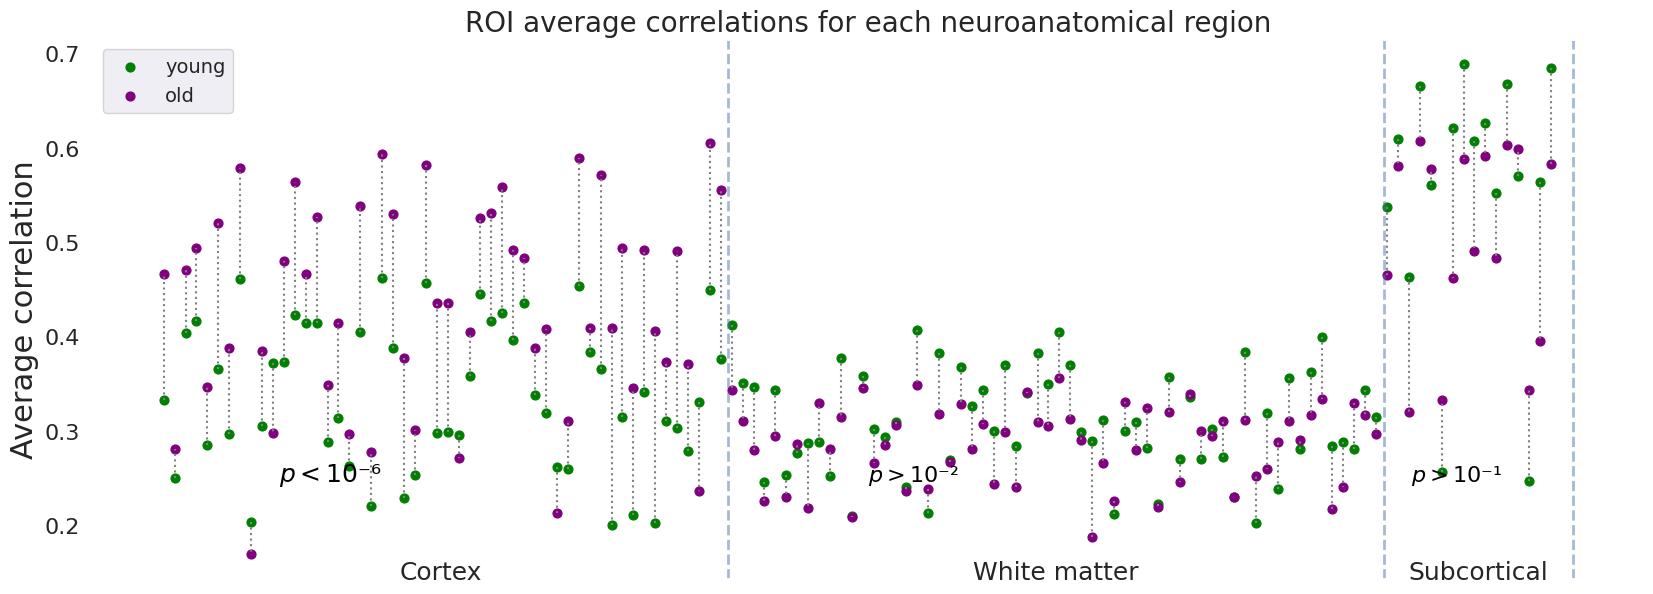

In [78]:
young_clusters, old_clusters, young_means, old_means = show_correlations_stats(chosen_data_z_score, young_data_z_score, old_data_z_score, 'pearson', divide=True, linkage_method='single')

In [74]:
ctx_young, wm_young, sub_young = young_means[:len(constants.ROI_CORTEX)], young_means[len(constants.ROI_CORTEX): len(constants.ROI_CORTEX) + len(constants.ROI_WM)], young_means[len(constants.ROI_CORTEX) + len(constants.ROI_WM):]
ctx_old, wm_old, sub_old = old_means[:len(constants.ROI_CORTEX)], old_means[len(constants.ROI_CORTEX): len(constants.ROI_CORTEX) + len(constants.ROI_WM)], old_means[len(constants.ROI_CORTEX) + len(constants.ROI_WM):]

for young_corr, old_corr, name in [(ctx_young, ctx_old, 'CTX'), (wm_young, wm_old, 'WM'), (sub_young, sub_old, 'SUB')]:
    results = stats.ttest_ind(a=young_corr, b=old_corr)
    significance = (results.pvalue <= 0.01/3)
    print(f'{name} {significance} {results.pvalue} {0.01/3}')


CTX True 2.3408844113220074e-06 0.0033333333333333335
WM False 0.010440274399014361 0.0033333333333333335
SUB False 0.19618015667359273 0.0033333333333333335


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:551: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



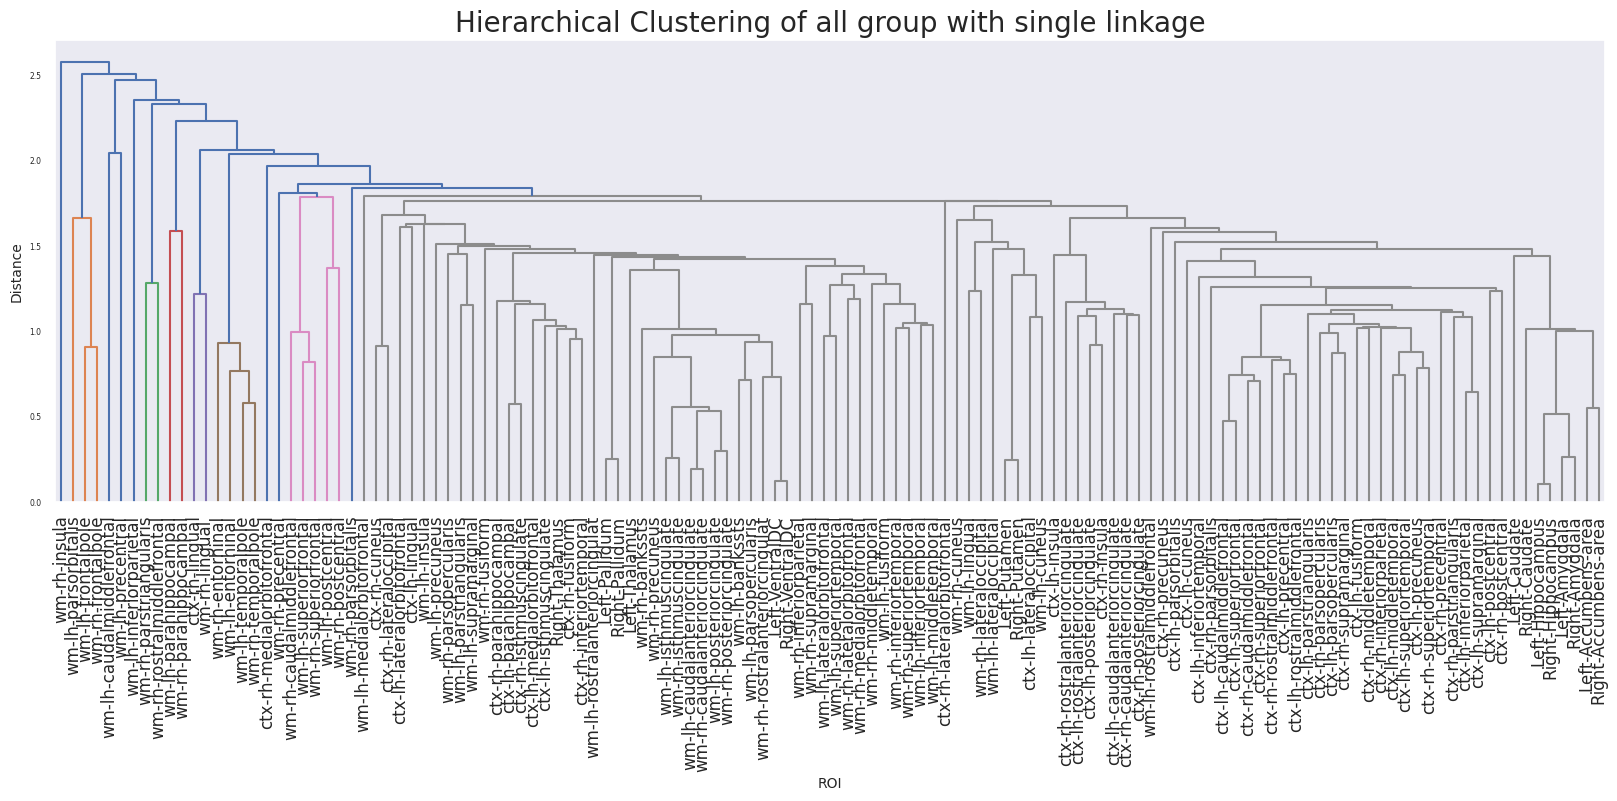

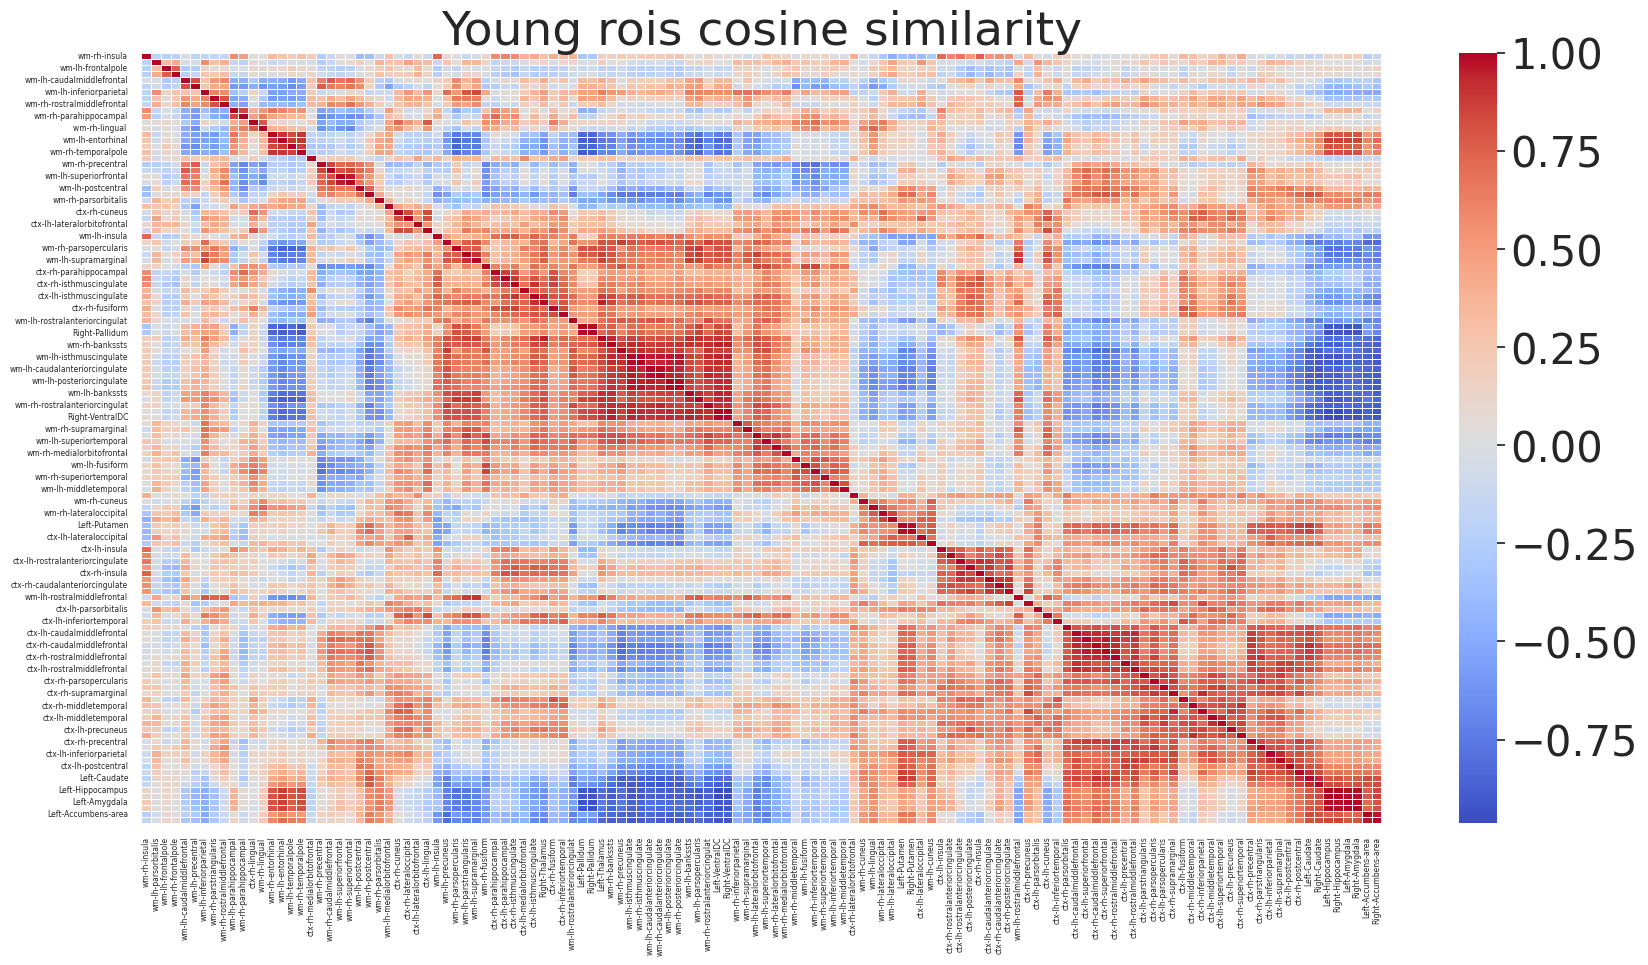

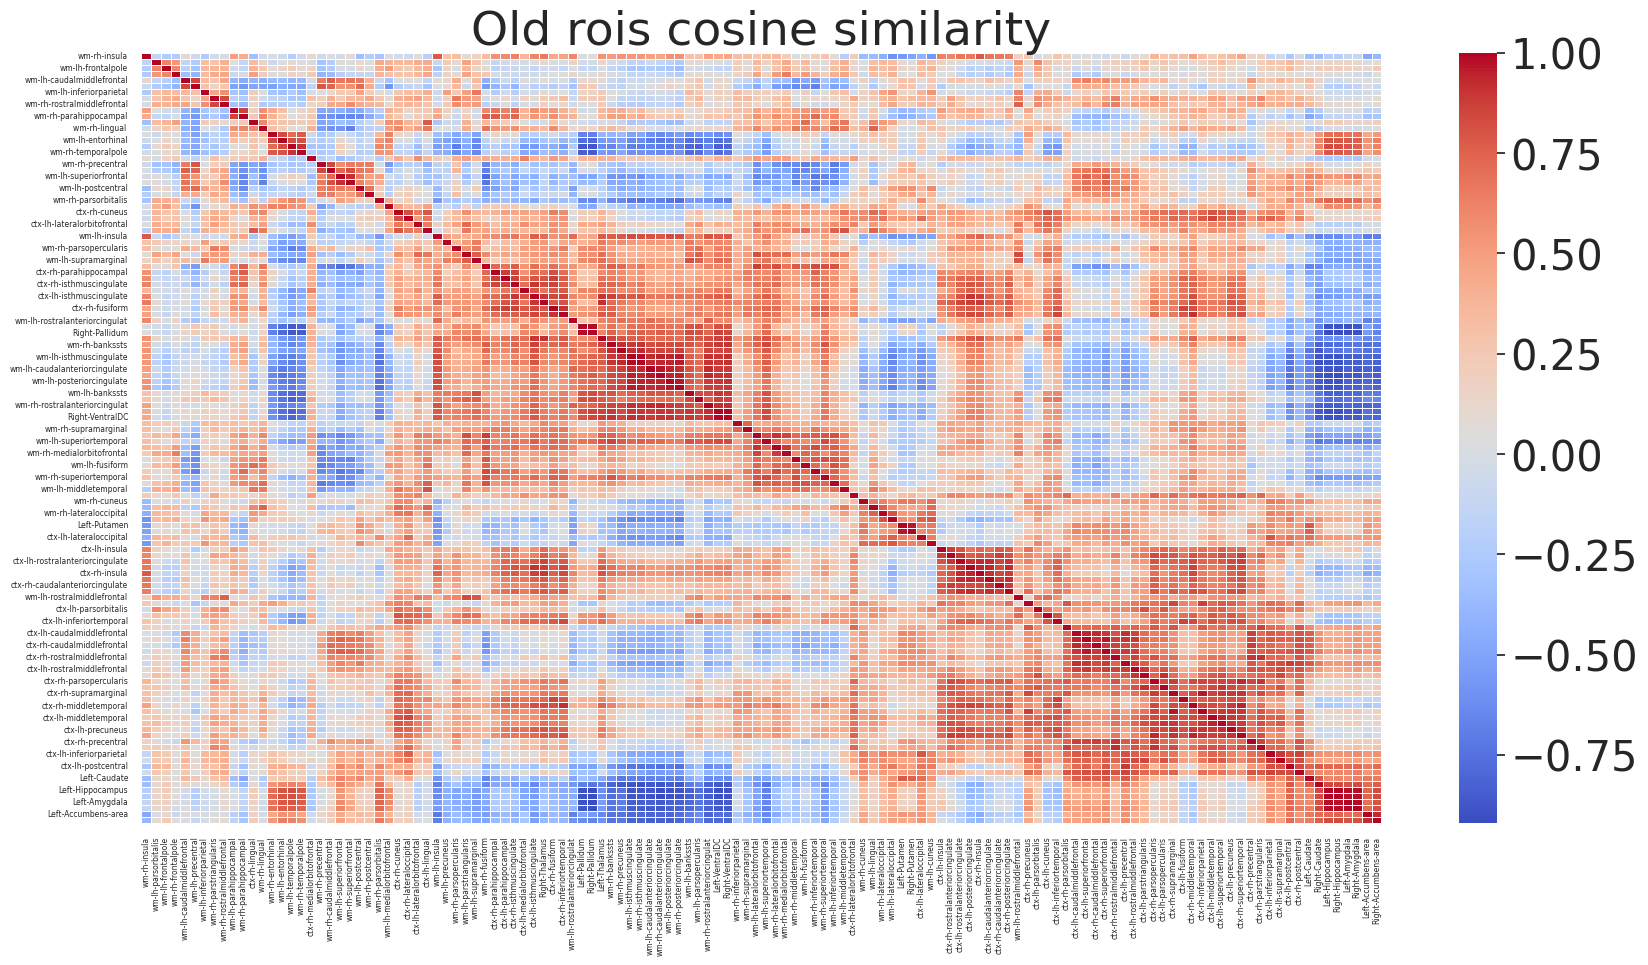

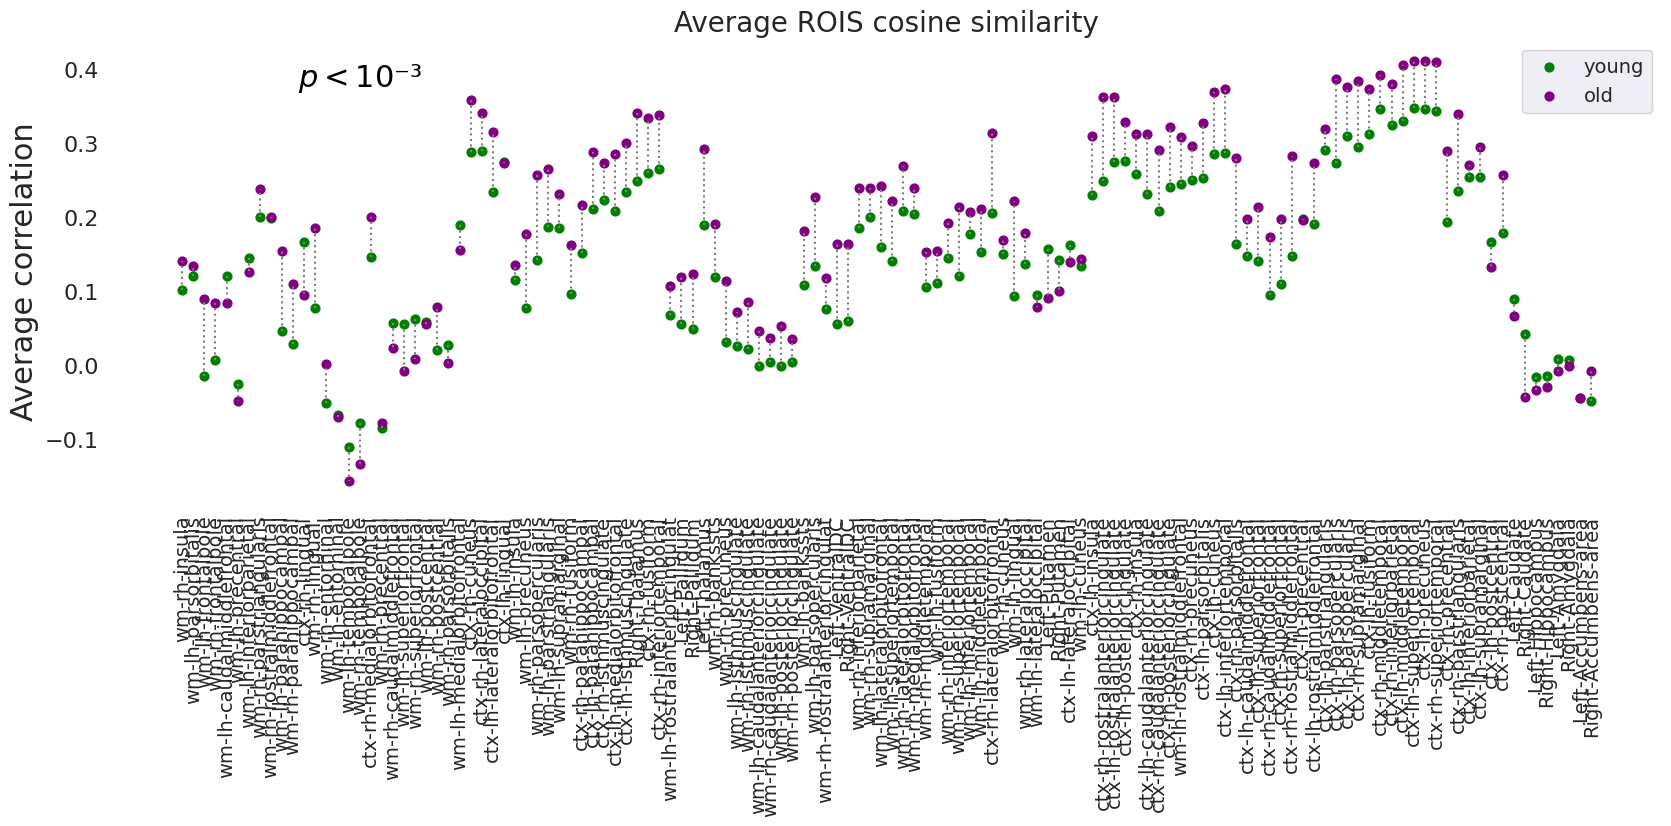

In [50]:
show_distances(cosine_similarity, params_to_work_with, chosen_data_z_score,
               young_data_z_score, old_data_z_score, 'cosine similarity')

Check t_test on the young and old groups

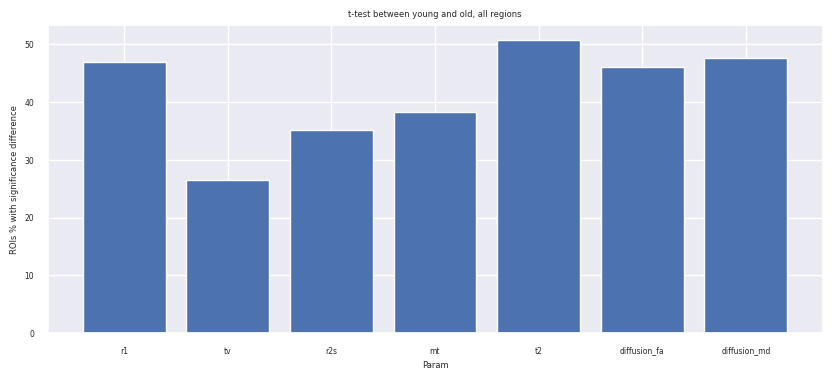

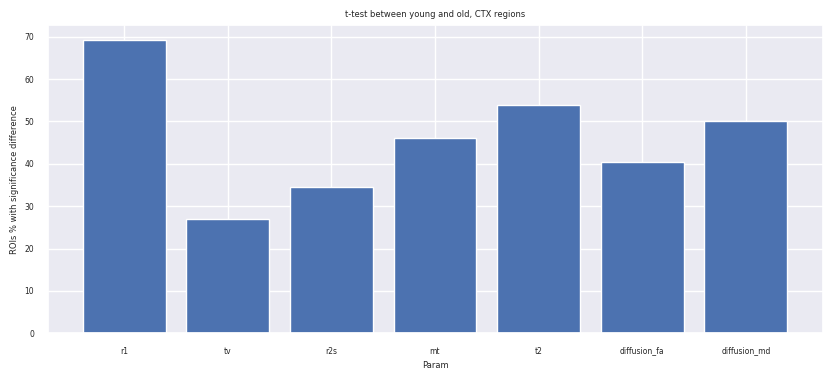

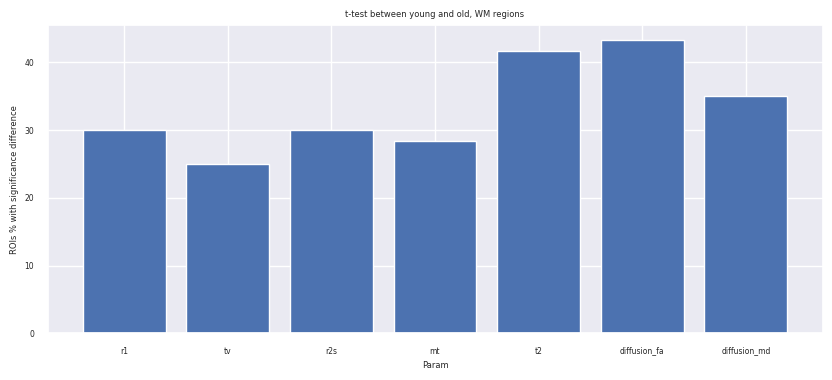

In [51]:
%autoreload 2
StatisticsWrapper.t_test_per_parameter_per_area(young_data_z_score, old_data_z_score, constants.ROI_ALL_BRAIN, 'ROI', params_to_work_with, 't-test between young and old, all regions')
StatisticsWrapper.t_test_per_parameter_per_area(young_data_z_score, old_data_z_score, constants.ROI_CORTEX, 'ROI', params_to_work_with, 't-test between young and old, CTX regions')
StatisticsWrapper.t_test_per_parameter_per_area(young_data_z_score, old_data_z_score, constants.ROI_WM, 'ROI', params_to_work_with, 't-test between young and old, WM regions')

Subjects clustering 

In [52]:
def reduce_dim(model, data, drop_label=True, pre_model=None):
    if pre_model:
        data = reduce_dim(pre_model, data)
    if drop_label:
        res = model.fit_transform(data.drop(columns='label'))
    else:
        res = model.fit(data.drop(columns='label'), data['label']).transform(
            data.drop(columns='label'))

    # Generate dynamic column names
    column_names = [f"var_{i + 1}" for i in range(res.shape[1])]
    reduced_data = pd.DataFrame(res, columns=column_names, index=data.index)

    reduced_data['label'] = data['label']
    return reduced_data, model

## Rois clustering

In [53]:
young_features_df = young_data_z_score.copy()
old_features_df = old_data_z_score.copy()


reduced_params = params_to_work_with + ['label']

# mean values
# young_features_df = young_features_df.groupby('ROI_name')[params_to_work_with].mean()
# old_features_df = old_features_df.groupby('ROI_name')[params_to_work_with].mean()

# Assign labels directly to DataFrame
young_features_df['label'] = 'young'
old_features_df['label'] = 'old'

all_features_df = pd.concat([young_features_df, old_features_df])

In [54]:

# def plot_clusters_of_rois(reduced_data, prev_data, prior_annot, search_col, title):
#     colors = sns.color_palette("Paired", len(prior_annot.keys()))
#     hue = []    
    
#     for roi in prev_data[search_col]:
#         for key, values in prior_annot.items():
#             if roi in values:
#                 hue.append(key)
                
#     ax = sns.scatterplot(
#         x="var_1", y="var_2",
#         hue=hue,
#         palette=colors,
#         data=reduced_data,
#         legend="full",
#     ).set_title(title, fontsize=12)

#     plt.legend(fontsize='12')

def plot_clusters_of_rois(reduced_data, prev_data, prior_annot, search_col, title, axis=False):
    # Initialize the color palette for the hue categories
    colors = sns.color_palette("tab10", len(prior_annot.keys()))
    hue = []
    indices_to_keep = []

    # Populate the hue list based on matching 'roi' in prev_data and 'prior_annot'
    for i, roi in enumerate(prev_data[search_col]):
        for key, values in prior_annot.items():
            if roi in values:
                hue.append(key)
                indices_to_keep.append(i)

    # Filter the reduced_data to only keep rows corresponding to the valid hue values
    filtered_data = reduced_data.iloc[indices_to_keep]

    # Plot using the filtered data and corresponding hues
    ax = sns.scatterplot(
        x="var_1", y="var_2",
        hue=hue,
        palette=colors,
        data=filtered_data,
        legend="full",
    )
    ax.set_title(title, fontsize=14)

    ax.legend(fontsize='12', loc='upper left')
    ax.grid(False)
    ax.set_facecolor('white')
    if not axis:
        ax.set_xticks([])
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_yticks([])
    

In [55]:
model, model_name = TSNE(n_components=2, perplexity=100, random_state=0), 't-SNE'
pca, model_name = PCA(n_components=2), 'PCA'
pca_95, model_name = PCA(n_components=0.95), 'PCA'
all_df_reduced, _ = reduce_dim(model, all_features_df[reduced_params])
all_df_reduced_pca, pca = reduce_dim(pca, all_features_df[reduced_params])
all_df_reduced_pca95, _ = reduce_dim(pca_95, all_features_df[reduced_params])
pass

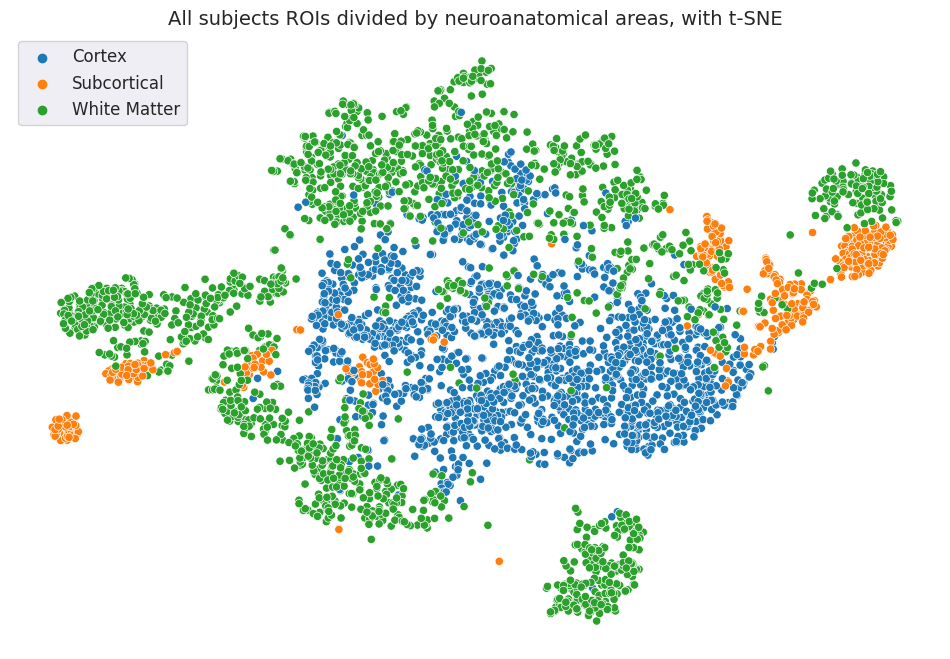

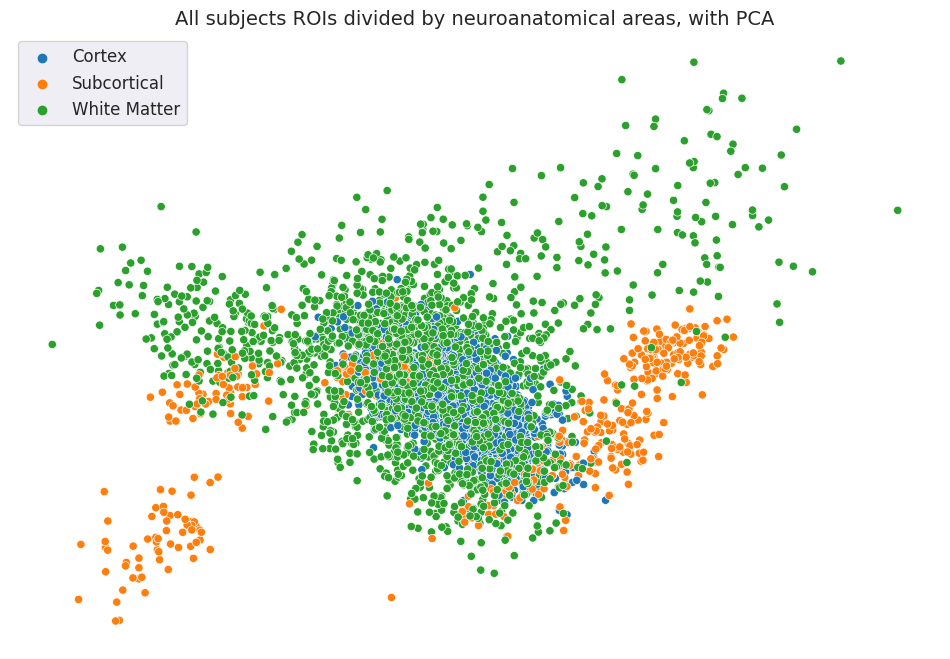

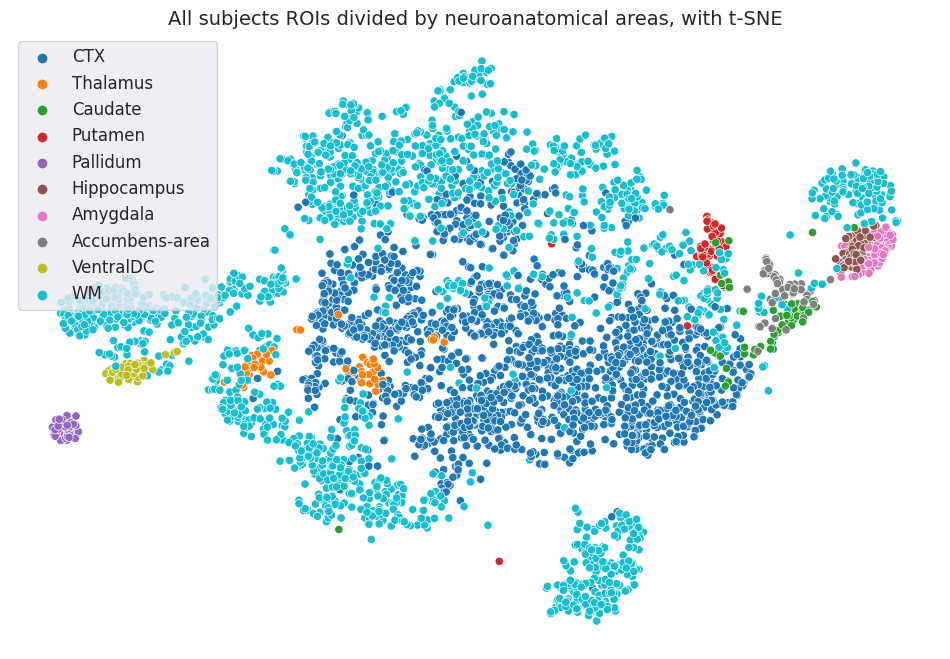

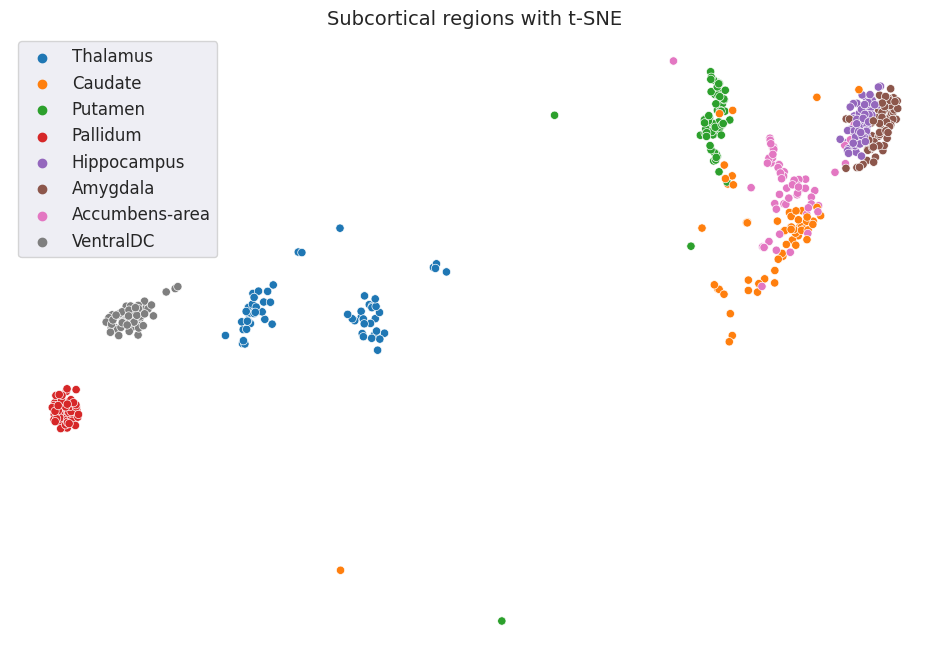

In [56]:
sub_matter = {
    "Cortex": constants.ROI_CORTEX.values(),
    "White Matter": constants.ROI_WM.values(),
    "Subcortical": constants.ROI_SUBCORTEX.values()
}
sub_ctx = {
    'Thalamus': ['Left-Thalamus', 'Right-Thalamus'],
    'Caudate': ['Left-Caudate', 'Right-Caudate'],
    'Putamen': ['Left-Putamen', 'Right-Putamen'],
    'Pallidum': ['Left-Pallidum', 'Right-Pallidum'],
    'Hippocampus': ['Left-Hippocampus', 'Right-Hippocampus'],
    'Amygdala': ['Left-Amygdala', 'Right-Amygdala'],
    'Accumbens-area': ['Left-Accumbens-area', 'Right-Accumbens-area'],
    'VentralDC': ['Left-VentralDC', 'Right-VentralDC'],
}

detailed_sub_matter = {
    "CTX": constants.ROI_CORTEX.values(),
    "WM": constants.ROI_WM.values(),
    'Thalamus': ['Left-Thalamus', 'Right-Thalamus'],
    'Caudate': ['Left-Caudate', 'Right-Caudate'],
    'Putamen': ['Left-Putamen', 'Right-Putamen'],
    'Pallidum': ['Left-Pallidum', 'Right-Pallidum'],
    'Hippocampus': ['Left-Hippocampus', 'Right-Hippocampus'],
    'Amygdala': ['Left-Amygdala', 'Right-Amygdala'],
    'Accumbens-area': ['Left-Accumbens-area', 'Right-Accumbens-area'],
    'VentralDC': ['Left-VentralDC', 'Right-VentralDC'],
}
plt.figure(figsize=(12, 8))
plot_clusters_of_rois(all_df_reduced, all_features_df, sub_matter,
                      'ROI_name',
                      title=f"All subjects ROIs divided by neuroanatomical areas, with t-SNE")
plt.figure(figsize=(12, 8))
plot_clusters_of_rois(all_df_reduced_pca, all_features_df, sub_matter,
                      'ROI_name',
                      title=f"All subjects ROIs divided by neuroanatomical areas, with PCA")
plt.figure(figsize=(12, 8))
plot_clusters_of_rois(all_df_reduced, all_features_df, detailed_sub_matter,
                      'ROI_name',
                      title=f"All subjects ROIs divided by neuroanatomical areas, with t-SNE")
plt.figure(figsize=(12, 8))
plot_clusters_of_rois(all_df_reduced, all_features_df, sub_ctx,
                      'ROI_name',
                      title=f"Subcortical regions with t-SNE")


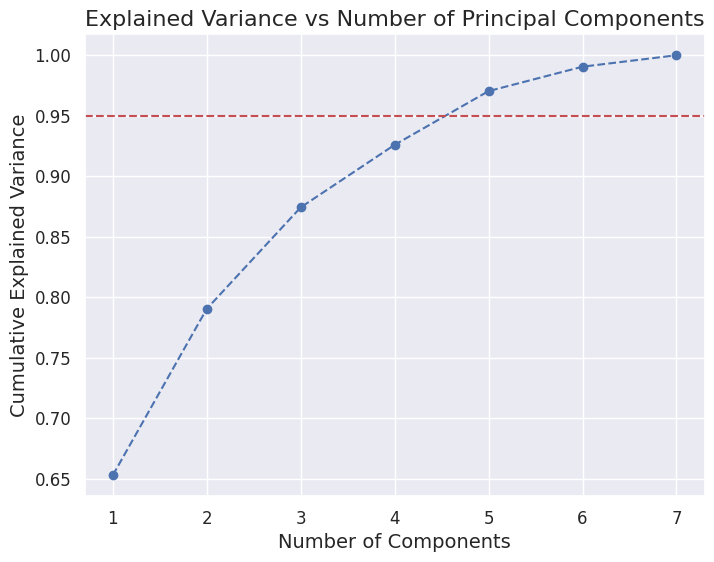

In [57]:
# Cumulative explained variance
pca = PCA().fit(all_features_df[reduced_params].drop(columns='label'))
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Explained Variance vs Number of Principal Components', fontsize=16)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

In [58]:
all_features_df = all_features_df[all_features_df["ROI"].isin(constants.ROI_CORTEX.keys())]
pca, model_name = PCA(n_components=0.95, random_state=42), 'PCA'
model, model_name = TSNE(n_components=2, perplexity=100, random_state=42, init='random'), 't-SNE'

all_df_reduced = reduce_dim(model, all_features_df[reduced_params], pre_model=pca)

# divide to hemi
all_features_df_lh_ix = all_features_df[all_features_df['ROI_name'].str.startswith('ctx-lh')].index
all_features_df_rh_ix = all_features_df[all_features_df['ROI_name'].str.startswith('ctx-rh')].index

AttributeError: 'tuple' object has no attribute 'drop'

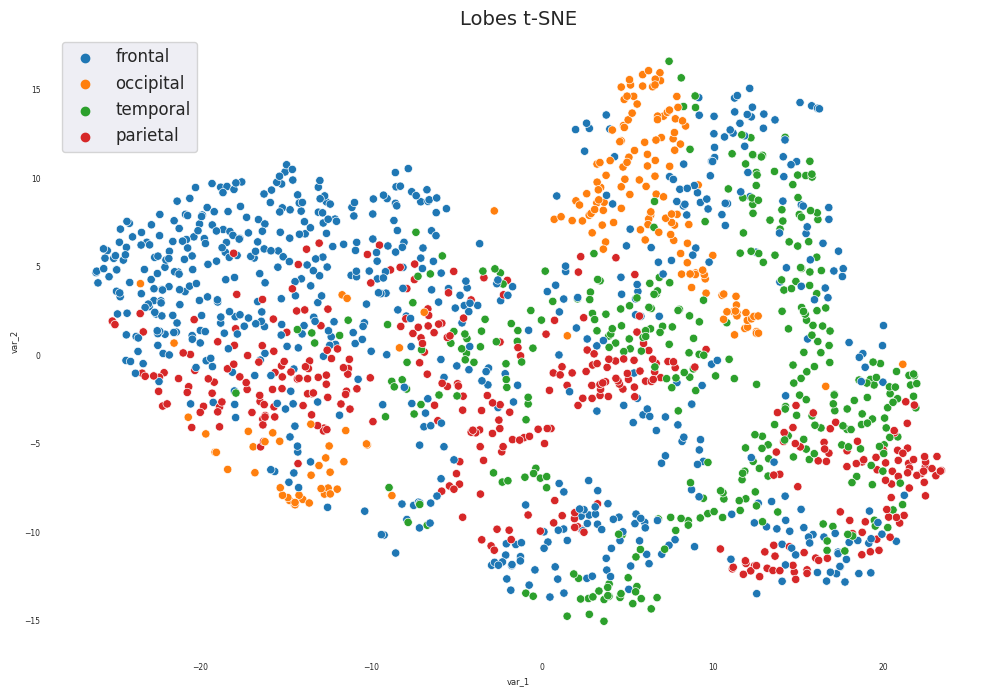

In [ ]:
plt.figure(figsize=(12, 8))
plot_clusters_of_rois(all_df_reduced,
                      all_features_df,
                      constants.LOBES, 'ROI_name',
                      title=f"Lobes {model_name}")

# plt.figure(figsize=(18, 14))
# plt.subplot(2, 2, 1)
# plot_clusters_of_rois(all_df_reduced.loc[all_features_df_lh_ix],
#                       all_features_df.loc[all_features_df_lh_ix],
#                       constants.LOBES, 'ROI_name',
#                       title=f"lh {model_name}")
# plt.subplot(2, 2, 2)
# plot_clusters_of_rois(all_df_reduced.loc[all_features_df_rh_ix],
#                       all_features_df.loc[all_features_df_rh_ix],
#                       constants.LOBES, 'ROI_name',
#                       title=f"rh {model_name}")

# raw data

In [ ]:
subjects_z_data = DataProcessor(
    constants.PATH_TO_CORTEX_all_params_z_score, constants.ROI_CORTEX, constants.ROI_CORTEX).get_data_proccessed()

subjects_z_data = StatisticsWrapper.chose_relevant_data(
    subjects_z_data, constants.ROI_CORTEX, params_to_work_with, params_to_work_with)

subjects_z_data = subjects_z_data.drop(columns=constants.SLOPES)

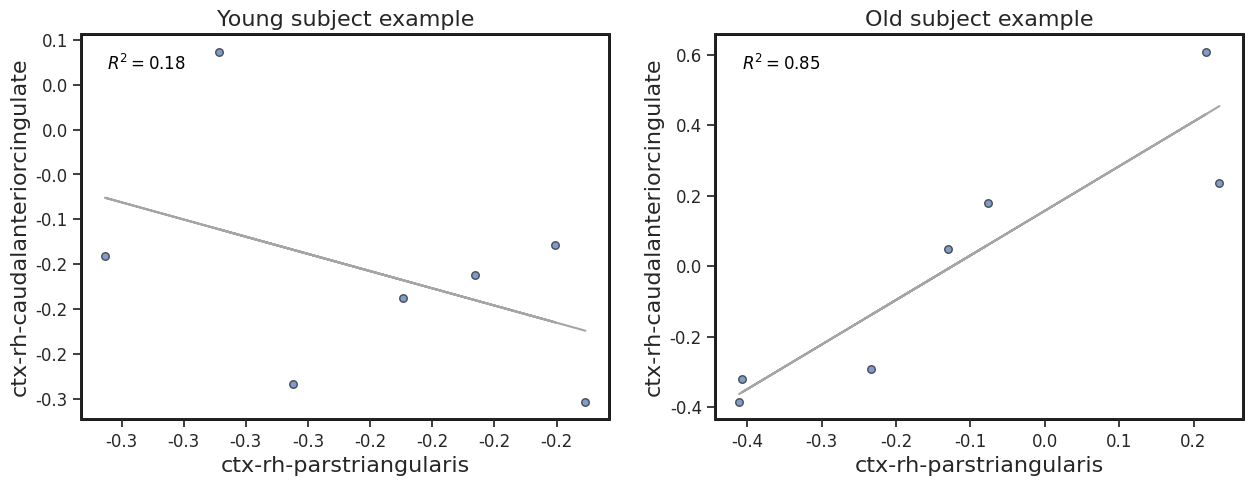

In [ ]:
roi1, roi2 = 'ctx-rh-parstriangularis', 'ctx-rh-caudalanteriorcingulate'

old_test = chosen_data_z_score[chosen_data_z_score['subjects'] == 'H019_AF']
young_test = chosen_data_z_score[chosen_data_z_score['subjects'] == 'H021_DH']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
StatisticsWrapper.check_linear_relation(old_test, roi1, roi2, params_to_work_with, ax[1], 'Old subject example')
StatisticsWrapper.check_linear_relation(young_test, roi1, roi2, params_to_work_with, ax[0], 'Young subject example')


In [ ]:
data_to_check_pairs = chosen_data_z_score[chosen_data_z_score['ROI'].isin(constants.ROI_CORTEX.keys())]
all_distances = StatisticsWrapper.roi_distances(
    data_to_check_pairs, params_to_work_with, method=cosine_similarity, title=f'', show=False)

# all_distances.rename(index={'wm-rh-lingual ': 'wm-rh-lingual'}, inplace=True)
# all_distances.rename(columns={'wm-rh-lingual ': 'wm-rh-lingual'}, inplace=True)

average_similar_pairs, average_rest, similar_dist, rest_dist = StatisticsWrapper.calculate_averages(all_distances)
t_test_pairs_res = stats.ttest_ind(a=similar_dist, b=rest_dist)
significance = t_test_pairs_res.pvalue <= 0.00001
print(significance, t_test_pairs_res.pvalue)

# Data for the bar chart
paris_data = {
    'Homologous pairs': average_similar_pairs,
    'Non Homologous pairs': average_rest
}

# Convert the data to a pandas Series for easy plotting
distances_series = pd.Series(paris_data)


True 2.6442041161819593e-10


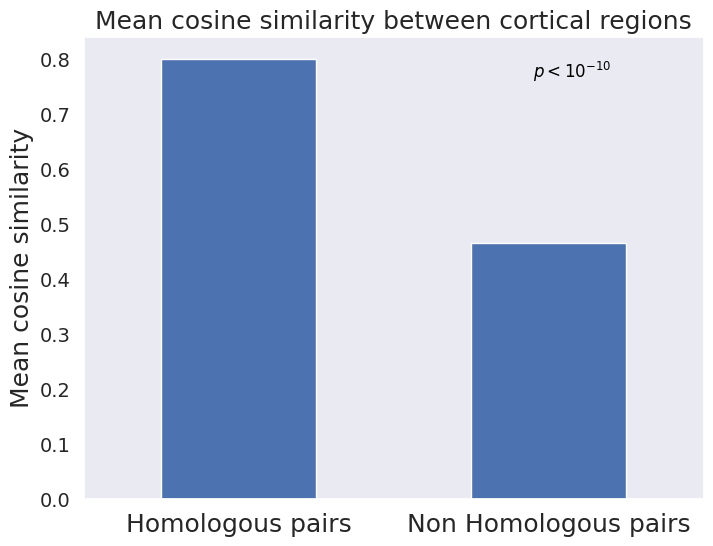

In [ ]:
plt.figure(figsize=(8, 6))
distances_series.plot(kind='bar')

# Adding titles and labels
plt.title('Mean cosine similarity between cortical regions', fontsize=18)
plt.ylabel('Mean cosine similarity', fontsize=18)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=14)
plt.text(0.95, 0.80, r"$p < 10^{-10}$",
            fontsize=12, verticalalignment='top', color='black')
plt.grid(False)

In [ ]:
raw_data = DataProcessor(constants.PATH_TO_ALL_BRAIN_all_params_raw,
                         constants.ROI_ALL_BRAIN, constants.ROI_ALL_BRAIN).get_data_proccessed()
rois_volume = {}

for roi, roi_data in raw_data.groupby('ROI_name'):
    roi_volumes = 0
    for i, value in roi_data.iterrows():
        roi_volumes += value['r1'].shape[0]
        

    roi_volumes /= len(roi_data)
    rois_volume[roi] = roi_volumes

In [ ]:
np.mean(list(rois_volume.values()))

6461.144301470588